# EpochAI Benchmarks

In [119]:
"""
Load benchmark data directly from CSV files in the benchmark_data folder.
Supports both internal and external benchmark formats.
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
from collections import defaultdict
import glob

## Load benchmark scores from CSV files

In [ ]:
# ============================================================================
# CONFIGURATION
# ============================================================================

BENCHMARK_DATA_DIR = "benchmark_data"

# Mapping of CSV filenames to benchmark names (standard names)
BENCHMARK_NAME_MAP = {
    # Internal benchmarks
    "frontiermath.csv": "FrontierMath",
    "frontiermath_tier_4.csv": "FrontierMath Tier 4",
    "gpqa_diamond.csv": "GPQA Diamond",
    "math_level_5.csv": "MATH Level 5",
    "otis_mock_aime_2024_2025.csv": "OTIS Mock AIME 2024-2025",
    "swe_bench_verified.csv": "SWE-Bench Verified",
    "swe_bench_bash.csv": "SWE-Bench Bash Only",
    "chess_puzzles.csv": "Chess Puzzles",
    "simpleqa_verified.csv": "SimpleQA Verified",
    
    # External benchmarks - standard names
    "adversarial_nli_external.csv": "Adversarial NLI",
    "aider_polyglot_external.csv": "Aider Polyglot",
    "arc_agi_external.csv": "ARC-AGI",
    "arc_ai2_external.csv": "ARC (AI2)",
    "balrog_external.csv": "BALROG",
    "bbh_external.csv": "BIG-Bench Hard (BBH)",
    "bool_q_external.csv": "BoolQ",
    "cad_eval_external.csv": "CAD-Eval",
    "common_sense_qa_2_external.csv": "CommonsenseQA 2.0",
    "cybench_external.csv": "Cybench",
    "deepresearchbench_external.csv": "DeepResearchBench",
    "epoch_capabilities_index_external.csv": "Epoch Capabilities Index",
    "factorio_learning_environment_external.csv": "Factorio Learning Environment",
    "fictionlivebench_external.csv": "Fiction.LiveBench",
    "geobench_external.csv": "GeoBench",
    "gsm8k_external.csv": "GSM8K",
    "gso_external.csv": "GSO-Bench",
    "hella_swag_external.csv": "HellaSwag",
    "lambada_external.csv": "LAMBADA",
    "lech_mazur_writing_external.csv": "Lech Mazur Writing",
    "live_bench_external.csv": "LiveBench",
    "metr_time_horizons_external.csv": "METR Time Horizons",
    "mmlu_external.csv": "MMLU",
    "open_book_qa_external.csv": "OpenBookQA",
    "os_universe_external.csv": "OSUniverse",
    "os_world_external.csv": "OS World (Screenshot)",
    "piqa_external.csv": "PIQA",
    "science_qa_external.csv": "ScienceQA",
    "simplebench_external.csv": "SimpleBench",
    "superglue_external.csv": "SuperGLUE",
    "terminalbench_external.csv": "TerminalBench",
    "the_agent_company_external.csv": "The Agent Company",
    "trivia_qa_external.csv": "TriviaQA",
    "video_mme_external.csv": "Video-MME",
    "vpct_external.csv": "VPCT",
    "webdev_arena_external.csv": "WebDev Arena",
    "weirdml_external.csv": "WeirdML",
    "wino_grande_external.csv": "WinoGrande",
}

# Mapping from benchmark name (or filename without extension) to score column
# Keys are lowercase for case-insensitive matching
BENCHMARK_SCORE_COLUMN_MAP = {
    # Internal benchmarks (use 'Best score (across scorers)')
    "frontiermath": "Best score (across scorers)",
    "frontiermath_tier_4": "Best score (across scorers)",
    "gpqa_diamond": "Best score (across scorers)",
    "math_level_5": "Best score (across scorers)",
    "otis_mock_aime_2024_2025": "Best score (across scorers)",
    "swe_bench_verified": "Best score (across scorers)",
    "swe_bench_bash": "% Resolved",
    "chess_puzzles": "Best score (across scorers)",
    "simpleqa_verified": "Best score (across scorers)",
    
    # External benchmarks - mapped from Airtable analysis
    "adversarial_nli": "Score",
    "aider_polyglot": "Percent correct",
    "arc_agi": "Score",
    "arc_ai2": "Challenge score",
    "balrog": "Average progress",
    "bbh": "Average",
    "bool_q": "Score",
    "cad_eval": "Overall pass (%)",
    "common_sense_qa_2": "Score",
    "cybench": "Unguided % Solved",
    "deepresearchbench": "Average score",
    "epoch_capabilities_index": "ECI Score",
    "factorio_learning_environment": "Lab Success %",
    "fictionlivebench": "16k token score",
    "geobench": "ACW Country %",
    "gsm8k": "EM",
    "gso": "Score OPT@1",
    "hella_swag": "Overall accuracy",
    "lambada": "Score",
    "lech_mazur_writing": "Mean score",
    "live_bench": "Global average",
    "metr_time_horizons": "average_score",
    "mmlu": "EM",
    "open_book_qa": "Accuracy",
    "os_universe": "Weighted Score",
    "os_world": "Score",
    "piqa": "Score",
    "science_qa": "Score",
    "simplebench": "Score (AVG@5)",
    "superglue": "Score",
    "terminalbench": "Accuracy mean",
    "the_agent_company": "% Resolved",
    "trivia_qa": "EM",
    "video_mme": "Overall (no subtitles)",
    "vpct": "Correct",
    "webdev_arena": "Arena Score",
    "weirdml": "Accuracy",
    "wino_grande": "Accuracy",
}

# Benchmarks that need score normalization (percentage to 0-1)
NORMALIZE_PERCENTAGE_BENCHMARKS = [
    "Aider Polyglot",
    "OS World (Screenshot)",
    "LiveBench",
]

# Benchmarks with 0, 10 scale
NORMALIZE_0_10_BENCHMARKS = [
    "Lech Mazur Writing"
]

# Benchmarks where scores are NOT normalized to 0-1 (keep raw values)
# These benchmarks have scores that naturally exceed 1.0
UNNORMALIZED_BENCHMARKS = [
    "Epoch Capabilities Index",
    "WebDev Arena",
    #"METR Time Horizons",
]

# CSV files to skip
EXCLUDED_CSV_FILES = {
    "arc_agi_external.csv"
}

In [165]:
# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def parse_date(date_value):
    """Parse a date from various formats.

    Note: US date format (m/d/Y) is tried before European format (d/m/Y)
    for ambiguous dates like 01/02/2024.
    """
    if date_value is None or pd.isna(date_value):
        return None
    if isinstance(date_value, datetime):
        return date_value.date()
    if isinstance(date_value, date):
        return date_value
    if isinstance(date_value, str):
        date_value = date_value.strip()
        if not date_value:
            return None
        # Try formats in order: ISO (unambiguous), US slash, European slash, year-month
        for fmt in ("%Y-%m-%d", "%Y-%m-%dT%H:%M:%S.%fZ", "%Y-%m-%dT%H:%M:%S",
                    "%Y/%m/%d", "%m/%d/%Y", "%d/%m/%Y", "%Y-%m"):
            try:
                return datetime.strptime(date_value.split('T')[0] if 'T' in date_value else date_value,
                                        fmt.split('T')[0]).date()
            except:
                continue
    return None

def parse_score(value):
    """Parse a score value, handling percentages and various formats."""
    if value is None or pd.isna(value):
        return None
    if isinstance(value, (int, float)):
        return float(value)
    
    # Handle string values
    val_str = str(value).strip()
    if not val_str or val_str.lower() in ('nan', 'na', 'none', '-', ''):
        return None
    
    # Handle percentage format
    if val_str.endswith('%'):
        val_str = val_str[:-1].strip()
        try:
            return float(val_str.replace(',', '.')) / 100.0
        except:
            return None
    
    # Handle comma as decimal separator
    val_str = val_str.replace(',', '.')
    
    try:
        return float(val_str)
    except:
        return None

def get_score_column_for_benchmark(filename, df_columns):
    """
    Get the score column for a benchmark based on filename.
    
    Args:
        filename: CSV filename (e.g., 'gsm8k_external.csv')
        df_columns: List of columns in the DataFrame
    
    Returns:
        Score column name
    
    Raises:
        ValueError: If score column cannot be found
    """
    # Normalize filename to key format
    key = os.path.splitext(filename)[0].lower()
    if key.endswith('_external'):
        key = key[:-9]  # Remove '_external'
    
    # Check direct mapping first
    if key in BENCHMARK_SCORE_COLUMN_MAP:
        score_col = BENCHMARK_SCORE_COLUMN_MAP[key]
        if score_col in df_columns:
            return score_col
        else:
            raise ValueError(
                f"Mapped column '{score_col}' not found in {filename}. "
                f"Available columns: {list(df_columns)}"
            )
    
    # If not in mapping, raise error
    raise ValueError(
        f"Benchmark '{key}' not found in BENCHMARK_SCORE_COLUMN_MAP. "
        f"Available columns in CSV: {list(df_columns)}. "
        f"Please add mapping to BENCHMARK_SCORE_COLUMN_MAP."
    )

def get_benchmark_name_from_filename(filename):
    """Extract benchmark name from filename."""
    # Check mapping first
    if filename in BENCHMARK_NAME_MAP:
        return BENCHMARK_NAME_MAP[filename]
    
    # Remove extension and _external suffix
    name = os.path.splitext(filename)[0]
    if name.endswith('_external'):
        name = name[:-9]  # Remove '_external'
    
    # Replace underscores with spaces for readability
    name = name.replace('_', ' ')
    
    # Title case
    name = name.title()
    
    return name

def is_unnormalized_benchmark(benchmark_name):
    """Check if benchmark should skip score normalization."""
    for bench in UNNORMALIZED_BENCHMARKS:
        if bench.lower() in benchmark_name.lower():
            return True
    return False

def normalize_score(score, benchmark_name):
    """Normalize score to 0, 1 range based on benchmark type."""
    if score is None:
        return None
    
    # Skip normalization for certain benchmarks
    if is_unnormalized_benchmark(benchmark_name):
        return score
    
    # Check if benchmark needs percentage normalization
    for bench in NORMALIZE_PERCENTAGE_BENCHMARKS:
        if bench.lower() in benchmark_name.lower():
            if score > 1:
                return score / 100.0
            return score
    
    # Check if benchmark uses 0, 10 scale
    for bench in NORMALIZE_0_10_BENCHMARKS:
        if bench.lower() in benchmark_name.lower():
            if score > 1:
                return score / 10.0
            return score
    
    return score

# ============================================================================
# CSV LOADING FUNCTIONS
# ============================================================================

def load_single_csv(filepath, benchmark_name=None):
    """
    Load a single benchmark CSV file and normalize it.
    
    Args:
        filepath: Path to the CSV file
        benchmark_name: Optional benchmark name (auto-detected from filename if not provided)
    
    Returns:
        DataFrame with normalized columns: model_version, score, release_date, 
        organization, benchmark, stderr
    """
    filename = os.path.basename(filepath)
    
    # Skip excluded files
    if filename in EXCLUDED_CSV_FILES:
        print(f"  Skipped (excluded): {filename}")
        return pd.DataFrame()
    
    if benchmark_name is None:
        benchmark_name = get_benchmark_name_from_filename(filename)
    
    # Try different separators
    df = None
    for sep in [',', ';', '\t']:
        try:
            df = pd.read_csv(filepath, sep=sep)
            if len(df.columns) > 1:
                break
        except:
            continue
    
    if df is None or df.empty:
        print(f"Warning: Empty or unreadable file: {filepath}")
        return pd.DataFrame()
    
    # Get score column using the mapping
    score_col = get_score_column_for_benchmark(filename, df.columns)
    if score_col is None:
        print(f"Warning: Could not detect score column in {filename}")
        print(f"  Available columns: {list(df.columns)}")
        return pd.DataFrame()
    
    # Check if this is an unnormalized benchmark
    skip_range_check = is_unnormalized_benchmark(benchmark_name)
    
    # Build normalized dataframe
    records = []
    skipped_invalid = 0
    
    for _, row in df.iterrows():
        # Get model version
        model_version = None
        for col in ['Model version', 'Model Version', 'model version', 'Name', 'Model', 'name']:
            if col in df.columns and pd.notna(row.get(col)):
                model_version = str(row[col]).strip()
                break
        
        if not model_version:
            continue
        
        # Get score
        score = parse_score(row.get(score_col))
        if score is None:
            continue
        
        # Normalize score if needed
        score = normalize_score(score, benchmark_name)
        
        # Validate score range (skip for unnormalized benchmarks)
        if not skip_range_check:
            if score is not None and (score < 0 or score > 1):
                # Score might already be in percentage, try normalizing
                if score > 1 and score <= 100:
                    score = score / 100.0
                elif score < 0 or score > 1:
                    skipped_invalid += 1
                    continue
        
        # Get release date
        release_date = None
        for col in ['Release date', 'Release Date', 'release_date', 'Date']:
            if col in df.columns:
                release_date = parse_date(row.get(col))
                if release_date:
                    break
        
        # Get organization
        organization = None
        for col in ['Organization', 'organization', 'Org']:
            if col in df.columns and pd.notna(row.get(col)):
                organization = str(row[col]).strip()
                break
        
        # Get stderr if available
        stderr = None
        for col in ['stderr', 'Stderr', 'SE', 'Standard Error', 'Margin of Error']:
            if col in df.columns:
                stderr = parse_score(row.get(col))
                if stderr is not None:
                    break
        
        # Get training compute if available
        training_compute = None
        for col in ['Training compute (FLOP)', 'training_compute', 'Compute']:
            if col in df.columns and pd.notna(row.get(col)):
                try:
                    training_compute = float(row[col])
                except:
                    pass
                break
        
        records.append({
            'model_version': model_version,
            'score': score,
            'release_date': release_date,
            'organization': organization,
            'benchmark': benchmark_name,
            'stderr': stderr,
            'training_compute': training_compute
        })
    
    result_df = pd.DataFrame(records)
    
    # Handle empty DataFrame case
    if result_df.empty:
        print(f"  Loaded 0 records from {filename}")
        print(f"    Benchmark: {benchmark_name}")
        print(f"    Score column: {score_col}")
        if skipped_invalid > 0:
            print(f"    Skipped {skipped_invalid} records with invalid scores")
        return result_df
    
    print(f"  Loaded {len(result_df)} records from {filename}")
    print(f"    Benchmark: {benchmark_name}")
    print(f"    Score column: {score_col}")
    print(f"    Records with dates: {result_df['release_date'].notna().sum()}")
    if skipped_invalid > 0:
        print(f"    Skipped {skipped_invalid} records with invalid scores")
    
    return result_df

def load_all_benchmarks(data_dir=BENCHMARK_DATA_DIR):
    """
    Load all benchmark CSV files from the data directory.
    
    Args:
        data_dir: Directory containing CSV files
    
    Returns:
        DataFrame with all benchmark data combined
    """
    print("="*80)
    print("LOADING BENCHMARK DATA FROM CSV FILES")
    print("="*80)
    
    # Find all CSV files
    csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {data_dir}")
        return pd.DataFrame()
    
    print(f"\nFound {len(csv_files)} CSV files in {data_dir}")
    
    all_data = []
    
    for filepath in sorted(csv_files):
        print(f"\nLoading: {os.path.basename(filepath)}")
        df = load_single_csv(filepath)
        if not df.empty:
            all_data.append(df)
    
    if not all_data:
        print("\nNo data loaded!")
        return pd.DataFrame()
    
    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Remove duplicates (same model, same benchmark)
    before = len(combined_df)
    combined_df = combined_df.drop_duplicates(
        subset=['model_version', 'benchmark', 'release_date'],
        keep='first'
    )
    after = len(combined_df)
    
    if before != after:
        print(f"\nRemoved {before - after} duplicate records")
    
    # Filter out future dates
    today = date.today()
    if 'release_date' in combined_df.columns and combined_df['release_date'].notna().any():
        future_mask = combined_df['release_date'].apply(lambda x: x > today if pd.notna(x) else False)
        future_count = future_mask.sum()
        if future_count > 0:
            print(f"\nWarning: Filtering out {future_count} records with future dates")
            combined_df = combined_df[~future_mask]
    
    # Summary
    print("\n" + "="*80)
    print("LOADING COMPLETE")
    print("="*80)
    print(f"\nTotal records: {len(combined_df)}")
    print(f"Benchmarks: {combined_df['benchmark'].nunique()}")
    print(f"Unique models: {combined_df['model_version'].nunique()}")
    
    if len(combined_df) > 0:
        dated_count = combined_df['release_date'].notna().sum()
        print(f"Records with dates: {dated_count} ({dated_count/len(combined_df)*100:.1f}%)")
        
        if combined_df['release_date'].notna().any():
            valid_dates = combined_df[combined_df['release_date'].notna()]['release_date']
            print(f"Date range: {valid_dates.min()} to {valid_dates.max()}")
    
    return combined_df

# ============================================================================
# BENCHMARK MATRICES EXTRACTION
# ============================================================================

def extract_benchmark_matrices(df):
    """
    Extract benchmark data as matrices for visualization and analysis.
    
    Args:
        df: DataFrame from load_all_benchmarks()
    
    Returns:
        dict: {
            benchmark_name: {
                'df_long': DataFrame in long format,
                'df_wide': DataFrame in wide format (dates × models),
                'n_observations': total observations,
                'n_models': number of unique models,
                'n_dates': number of unique dates,
                'density': matrix density (non-null / total)
            }
        }
    """
    # Filter to records with dates
    df_dated = df[df['release_date'].notna()].copy()
    
    if df_dated.empty:
        print("Warning: No records with release dates")
        return {}
    
    result = {}
    
    for benchmark in df_dated['benchmark'].unique():
        bench_df = df_dated[df_dated['benchmark'] == benchmark].copy()
        
        # Prepare long format
        data_rows = []
        for _, row in bench_df.iterrows():
            data_rows.append({
                'date': row['release_date'],
                'model_id': row['model_version'],
                'avg_score': row['score'],
                'stderr': row['stderr'],
                'organization': row['organization']
            })
        
        if not data_rows:
            continue
        
        df_long = pd.DataFrame(data_rows).sort_values(['date', 'model_id']).reset_index(drop=True)
        
        # Prepare wide format
        dates = sorted(df_long['date'].unique())
        models = sorted(df_long['model_id'].unique())
        
        matrix_data = []
        for d in dates:
            row = []
            for model in models:
                match = df_long[(df_long['date'] == d) & (df_long['model_id'] == model)]
                if not match.empty:
                    row.append(match.iloc[0]['avg_score'])
                else:
                    row.append(np.nan)
            matrix_data.append(row)
        
        df_wide = pd.DataFrame(matrix_data, index=dates, columns=models)
        
        # Calculate density
        total_cells = len(dates) * len(models)
        non_null = df_wide.notna().sum().sum()
        density = non_null / total_cells if total_cells > 0 else 0
        
        result[benchmark] = {
            'df_long': df_long,
            'df_wide': df_wide,
            'n_observations': len(data_rows),
            'n_models': len(models),
            'n_dates': len(dates),
            'density': density
        }
    
    return result

def print_benchmark_summary(benchmark_matrices):
    """Print a summary of all loaded benchmarks."""
    print("\n" + "="*80)
    print("BENCHMARK MATRICES SUMMARY")
    print("="*80)
    
    for benchmark, data in sorted(benchmark_matrices.items()):
        print(f"\n{benchmark}:")
        print(f"  Models: {data['n_models']}")
        print(f"  Dates: {data['n_dates']}")
        print(f"  Observations: {data['n_observations']}")
        print(f"  Matrix shape: {data['df_wide'].shape}")
        print(f"  Density: {data['density']:.1%}")

# ============================================================================
# FRONTIER EXTRACTION (for forecasting)
# ============================================================================

def _rank_models(models_data):
    """
    Sort and rank models according to specifications:
    - Higher score first
    - Earlier date first (for same score)
    - Equal ranks only for identical (score, date) pairs
    
    Args:
        models_data: list of (model, score, date) tuples
    
    Returns:
        List of (model, score, date, rank) tuples, sorted
    """
    if not models_data:
        return []
    
    # Sort: higher score, then earlier date, then alphabetical (for determinism)
    sorted_items = sorted(
        models_data,
        key=lambda x: (-x[1], x[2], x[0])
    )

    # Assign ranks: equal rank only if same score AND same date
    ranked = []
    prev_score, prev_date = None, None
    current_rank = 0
    
    for i, (model, score, date_achieved) in enumerate(sorted_items):
        if score != prev_score or date_achieved != prev_date:
            current_rank = i + 1
        ranked.append((model, score, date_achieved, current_rank))
        prev_score, prev_date = score, date_achieved
    
    return ranked

def _get_top_n_with_ties(ranked_models, top_n):
    """
    Get top N models, including all ties with the Nth model's score.
    
    Args:
        ranked_models: List of (model, score, date, rank) from _rank_models
        top_n: Number of top models to consider
    
    Returns:
        List of (model, score, date, rank) for top N + ties
    """
    if len(ranked_models) <= top_n:
        return ranked_models
    
    # Include all with rank <= top_n
    return [(m, s, d, r) for m, s, d, r in ranked_models if r <= top_n]

def extract_frontier(df, benchmark_name, top_n=3):
    """
    Extract the performance frontier for a benchmark.
    
    At each release date:
    - Re-rank all models seen so far (higher score, then earlier date)
    - Equal ranks only for identical (score, date) pairs
    - Record top-N models (+ score ties with Nth)
    
    Args:
        df: DataFrame from load_all_benchmarks()
        benchmark_name: Name of the benchmark
        top_n: Number of top models to consider at each date
    
    Returns:
        DataFrame with frontier data: date, score, model_version, rank, days
    """
    bench_df = df[(df['benchmark'] == benchmark_name) & (df['release_date'].notna())].copy()
    
    if bench_df.empty:
        print(f"Warning: No dated records for {benchmark_name}")
        return pd.DataFrame()
    
    dates = sorted(bench_df['release_date'].unique())
    if not dates:
        return pd.DataFrame()
    
    min_date = dates[0]
    frontier_records = []
    recorded = set()  # (model, score, date_achieved)
    all_models = []   # List of (model, score, date) tuples
    
    for d in dates:
        # Add all new models released at this date
        for _, row in bench_df[bench_df['release_date'] == d].iterrows():
            all_models.append((row['model_version'], row['score'], d))
        
        # Rank all models and get top-N with ties
        top_models = _get_top_n_with_ties(_rank_models(all_models), top_n)
        
        # Record new entries
        for model, score, date_achieved, rank in top_models:
            key = (model, score, date_achieved)
            if key not in recorded:
                recorded.add(key)
                frontier_records.append({
                    'date': date_achieved,
                    'score': score,
                    'model_version': model,
                    'rank': rank,
                    'days': (date_achieved - min_date).days
                })
    
    if not frontier_records:
        return pd.DataFrame()
    
    return pd.DataFrame(frontier_records).sort_values(
        ['date', 'rank', 'model_version']
    ).reset_index(drop=True)

def extract_all_frontiers(df, top_n=3):
    """
    Extract frontiers for all benchmarks.
    
    Args:
        df: DataFrame from load_all_benchmarks()
        top_n: Number of top models to consider
    
    Returns:
        dict: {benchmark_name: frontier_df}
    """
    frontiers = {}
    
    for benchmark in df['benchmark'].unique():
        frontier = extract_frontier(df, benchmark, top_n)
        if not frontier.empty:
            frontiers[benchmark] = frontier
    
    return frontiers

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_benchmark_frontier(df, benchmark_name, ax=None, show_all_points=True):
    """
    Plot the performance frontier for a single benchmark.
    
    Args:
        df: DataFrame from load_all_benchmarks()
        benchmark_name: Name of the benchmark
        ax: Matplotlib axes (creates new figure if None)
        show_all_points: Whether to show all data points or just frontier
    """
    bench_df = df[(df['benchmark'] == benchmark_name) & (df['release_date'].notna())].copy()
    
    if bench_df.empty:
        print(f"No data for {benchmark_name}")
        return
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Sort by date
    bench_df = bench_df.sort_values('release_date')
    
    # Plot all points if requested
    if show_all_points:
        ax.scatter(bench_df['release_date'], bench_df['score'], 
                  s=30, alpha=0.3, color='#2E86AB', label='All scores')
    
    # Calculate and plot frontier
    best_score = float('-inf')
    frontier_dates = []
    frontier_scores = []
    
    for _, row in bench_df.iterrows():
        if row['score'] > best_score:
            best_score = row['score']
            frontier_dates.append(row['release_date'])
            frontier_scores.append(row['score'])
    
    if frontier_dates:
        # Create step function
        step_dates = [frontier_dates[0]]
        step_scores = [frontier_scores[0]]
        
        for i in range(1, len(frontier_dates)):
            step_dates.append(frontier_dates[i])
            step_scores.append(frontier_scores[i-1])
            step_dates.append(frontier_dates[i])
            step_scores.append(frontier_scores[i])
        
        # Extend to current date
        step_dates.append(date.today())
        step_scores.append(frontier_scores[-1])
        
        ax.plot(step_dates, step_scores, '-', linewidth=2, color='#2E86AB', label='Frontier')
        ax.scatter(frontier_dates, frontier_scores, s=60, color='#2E86AB', zorder=5)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(benchmark_name, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    return ax

def plot_all_benchmarks_grid(df, cols=3, figsize=(15, 4)):
    """
    Plot all benchmarks in a grid layout.
    
    Args:
        df: DataFrame from load_all_benchmarks()
        cols: Number of columns in grid
        figsize: Size per subplot (width, height)
    """
    benchmarks = sorted(df['benchmark'].unique())
    n_benchmarks = len(benchmarks)
    rows = int(np.ceil(n_benchmarks / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0] * cols, figsize[1] * rows))
    axes = axes.flatten() if n_benchmarks > 1 else [axes]
    
    for idx, benchmark in enumerate(benchmarks):
        plot_benchmark_frontier(df, benchmark, ax=axes[idx])
    
    # Hide unused subplots
    for idx in range(n_benchmarks, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()



In [131]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

# Load all benchmark data
df_epochai = load_all_benchmarks(BENCHMARK_DATA_DIR)

# Display sample data
print("\n" + "="*80)
print("SAMPLE DATA")
print("="*80)
print(df_epochai.head(20))

LOADING BENCHMARK DATA FROM CSV FILES

Found 45 CSV files in benchmark_data

Loading: adversarial_nli_external.csv
  Loaded 16 records from adversarial_nli_external.csv
    Benchmark: Adversarial NLI
    Score column: Score
    Records with dates: 15

Loading: aider_polyglot_external.csv
  Loaded 63 records from aider_polyglot_external.csv
    Benchmark: Aider Polyglot
    Score column: Percent correct
    Records with dates: 62

Loading: arc_agi_external.csv
  Skipped (excluded): arc_agi_external.csv

Loading: arc_ai2_external.csv
  Loaded 142 records from arc_ai2_external.csv
    Benchmark: ARC (AI2)
    Score column: Challenge score
    Records with dates: 133

Loading: balrog_external.csv
  Loaded 27 records from balrog_external.csv
    Benchmark: BALROG
    Score column: Average progress
    Records with dates: 27

Loading: bbh_external.csv
  Loaded 90 records from bbh_external.csv
    Benchmark: BIG-Bench Hard (BBH)
    Score column: Average
    Records with dates: 86

Loading: b

/var/folders/ct/fw960pjx4l1d652ll2y6zk5c0000gp/T/ipykernel_65522/4176522176.py:329: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data, ignore_index=True)


## Test Loading function

In [ ]:
# ============================================================================
# TESTS FOR CSV LOADING FUNCTIONS
# ============================================================================

def run_csv_loading_tests():
    """Run all tests for the CSV loading functions."""
    
    tests_passed = 0
    tests_failed = 0
    
    def test(name, condition, error_msg=""):
        nonlocal tests_passed, tests_failed
        try:
            assert condition, error_msg
            print(f"✓ {name}")
            tests_passed += 1
        except AssertionError as e:
            print(f"✗ {name}: {e}")
            tests_failed += 1
        except Exception as e:
            print(f"✗ {name}: Unexpected error - {e}")
            tests_failed += 1
    
    print("="*80)
    print("RUNNING CSV LOADING TESTS")
    print("="*80)
    
    # ========================================================================
    # Test 1: parse_date function
    # ========================================================================
    print("\n[1] Testing parse_date...")
    test("Parse ISO date", parse_date("2023-03-14") == date(2023, 3, 14))
    test("Parse datetime string", parse_date("2023-03-14T12:00:00.000Z") == date(2023, 3, 14))
    test("Parse EU date", parse_date("14/03/2023") == date(2023, 3, 14))
    test("Parse year-month", parse_date("2023-03") == date(2023, 3, 1))
    test("Parse None returns None", parse_date(None) is None)
    test("Parse empty string returns None", parse_date("") is None)
    test("Parse NaN returns None", parse_date(np.nan) is None)
    test("Parse date object returns same", parse_date(date(2023, 3, 14)) == date(2023, 3, 14))
    test("Parse datetime object returns date", parse_date(datetime(2023, 3, 14, 12, 0)) == date(2023, 3, 14))
    
    # ========================================================================
    # Test 2: parse_score function
    # ========================================================================
    print("\n[2] Testing parse_score...")
    test("Parse float", parse_score(0.856) == 0.856)
    test("Parse int", parse_score(1) == 1.0)
    test("Parse string decimal", parse_score("0.856") == 0.856)
    test("Parse percentage string", abs(parse_score("85.6%") - 0.856) < 0.001)
    test("Parse comma decimal", parse_score("0,856") == 0.856)
    test("Parse comma percentage", abs(parse_score("85,6%") - 0.856) < 0.001)
    test("Parse None returns None", parse_score(None) is None)
    test("Parse empty string returns None", parse_score("") is None)
    test("Parse NaN returns None", parse_score(np.nan) is None)
    test("Parse 'nan' string returns None", parse_score("nan") is None)
    test("Parse dash returns None", parse_score("-") is None)
    
        # ========================================================================
    # Test 3: get_benchmark_name_from_filename function
    # ========================================================================
    print("\n[3] Testing get_benchmark_name_from_filename...")
    test("Internal benchmark mapping", 
         get_benchmark_name_from_filename("frontiermath.csv") == "FrontierMath")
    test("External benchmark with suffix (mapped)", 
         get_benchmark_name_from_filename("gsm8k_external.csv") == "GSM8K")
    test("LiveBench mapping", 
         get_benchmark_name_from_filename("live_bench_external.csv") == "LiveBench")
    test("MMLU mapping", 
         get_benchmark_name_from_filename("mmlu_external.csv") == "MMLU")
    test("ARC-AGI mapping",
         get_benchmark_name_from_filename("arc_agi_external.csv") == "ARC-AGI")
    test("BBH mapping",
         get_benchmark_name_from_filename("bbh_external.csv") == "BIG-Bench Hard (BBH)")
    
    # ========================================================================
    # Test 4: get_score_column_for_benchmark function
    # ========================================================================
    print("\n[4] Testing get_score_column_for_benchmark...")
    
    # Test with valid mapping
    test_columns = ['Name', 'Score', 'Release date']
    try:
        result = get_score_column_for_benchmark("arc_agi_external.csv", test_columns)
        test("Returns mapped column", result == "Score")
    except ValueError as e:
        test("Returns mapped column", False, str(e))
    
    # Test with missing column
    try:
        get_score_column_for_benchmark("arc_agi_external.csv", ['Name', 'Other'])
        test("Raises error for missing column", False, "Should have raised ValueError")
    except ValueError as e:
        test("Raises error for missing column", "not found" in str(e).lower())
    
    # Test with unmapped benchmark
    try:
        get_score_column_for_benchmark("unknown_benchmark.csv", ['Name', 'Score'])
        test("Raises error for unmapped benchmark", False, "Should have raised ValueError")
    except ValueError as e:
        test("Raises error for unmapped benchmark", "not found in BENCHMARK_SCORE_COLUMN_MAP" in str(e))
    
    # ========================================================================
    # Test 5: is_unnormalized_benchmark function
    # ========================================================================
    print("\n[5] Testing is_unnormalized_benchmark...")
    test("Epoch Capabilities Index is unnormalized", 
         is_unnormalized_benchmark("Epoch Capabilities Index") == True)
    test("Webdev Arena is unnormalized", 
         is_unnormalized_benchmark("Webdev Arena") == True)
    test("MMLU is normalized", 
         is_unnormalized_benchmark("MMLU") == False)
    test("Case insensitive", 
         is_unnormalized_benchmark("epoch capabilities index") == True)
    
    # ========================================================================
    # Test 6: normalize_score function
    # ========================================================================
    print("\n[6] Testing normalize_score...")
    test("None returns None", normalize_score(None, "MMLU") is None)
    test("Normal score unchanged", normalize_score(0.85, "MMLU") == 0.85)
    test("Unnormalized benchmark keeps raw", normalize_score(150, "Epoch Capabilities Index") == 150)
    test("Percentage benchmark normalized", normalize_score(85.6, "Aider polyglot") == 0.856)
    test("0-10 scale benchmark normalized", normalize_score(8.5, "Lech Mazur Writing") == 0.85)
    test("Already normalized percentage", normalize_score(0.856, "Aider polyglot") == 0.856)
    
    # ========================================================================
    # Test 7: DataFrame loaded correctly (if data exists)
    # ========================================================================
    print("\n[7] Testing loaded DataFrame...")
    
    if 'df_epochai' in globals() and len(df_epochai) > 0:
        test("DataFrame not empty", len(df_epochai) > 0)
        test("Has model_version column", 'model_version' in df_epochai.columns)
        test("Has score column", 'score' in df_epochai.columns)
        test("Has release_date column", 'release_date' in df_epochai.columns)
        test("Has benchmark column", 'benchmark' in df_epochai.columns)
        
        # Check score ranges for normalized benchmarks
        normalized_scores = df_epochai[
            ~df_epochai['benchmark'].apply(is_unnormalized_benchmark)
        ]['score'].dropna()
        
        if len(normalized_scores) > 0:
            test("Normalized scores >= 0", (normalized_scores >= 0).all())
            test("Normalized scores <= 1", (normalized_scores <= 1).all(),
                 f"Max: {normalized_scores.max()}")
        
        # Check no future dates
        dated = df_epochai[df_epochai['release_date'].notna()]
        if len(dated) > 0:
            test("No future dates", 
                 (dated['release_date'] <= date.today()).all())
        
        # Check multiple benchmarks loaded
        n_benchmarks = df_epochai['benchmark'].nunique()
        test("Multiple benchmarks loaded", n_benchmarks > 1, 
             f"Only {n_benchmarks} benchmark(s)")
        
        # Check no duplicate records
        duplicates = df_epochai.duplicated(
            subset=['model_version', 'benchmark', 'release_date'],
            keep=False
        )
        test("No duplicate records", duplicates.sum() == 0,
             f"Found {duplicates.sum()} duplicates")
    else:
        print("  ⚠ df_epochai not loaded or empty - skipping DataFrame tests")
    
    # ========================================================================
    # Test 8: Benchmark matrices extraction
    # ========================================================================
    print("\n[8] Testing extract_benchmark_matrices...")
    
    if 'df_epochai' in globals() and len(df_epochai) > 0:
        matrices = extract_benchmark_matrices(df_epochai)
        
        if matrices:
            test("Matrices dict not empty", len(matrices) > 0)
            
            for benchmark, data in list(matrices.items())[:2]:
                test(f"{benchmark[:25]} has df_long", 
                     isinstance(data.get('df_long'), pd.DataFrame))
                test(f"{benchmark[:25]} has df_wide", 
                     isinstance(data.get('df_wide'), pd.DataFrame))
                test(f"{benchmark[:25]} df_long not empty", 
                     len(data['df_long']) > 0)
                test(f"{benchmark[:25]} has n_models", 
                     isinstance(data.get('n_models'), int) and data['n_models'] > 0)
                test(f"{benchmark[:25]} has n_dates", 
                     isinstance(data.get('n_dates'), int) and data['n_dates'] > 0)
                test(f"{benchmark[:25]} density in [0,1]", 
                     0 <= data.get('density', -1) <= 1)
                
                # Check df_long structure
                df_long = data['df_long']
                test(f"{benchmark[:25]} df_long has date", 'date' in df_long.columns)
                test(f"{benchmark[:25]} df_long has model_id", 'model_id' in df_long.columns)
                test(f"{benchmark[:25]} df_long has avg_score", 'avg_score' in df_long.columns)
        else:
            print("  ⚠ No matrices extracted - may be no dated records")
    else:
        print("  ⚠ df_epochai not loaded - skipping matrix tests")
    
    # ========================================================================
    # Test 9: Frontier extraction
    # ========================================================================
    print("\n[9] Testing extract_frontier...")
    
    if 'df_epochai' in globals() and len(df_epochai) > 0:
        benchmarks_with_dates = df_epochai[
            df_epochai['release_date'].notna()
        ]['benchmark'].unique()
        
        if len(benchmarks_with_dates) > 0:
            test_benchmark = benchmarks_with_dates[0]
            frontier = extract_frontier(df_epochai, test_benchmark, top_n=3)
            
            if not frontier.empty:
                test("Frontier not empty", len(frontier) > 0)
                test("Frontier has date", 'date' in frontier.columns)
                test("Frontier has score", 'score' in frontier.columns)
                test("Frontier has model_version", 'model_version' in frontier.columns)
                test("Frontier has rank", 'rank' in frontier.columns)
                test("Frontier has days", 'days' in frontier.columns)
                test("Frontier sorted by date", 
                     (frontier['date'].diff().dropna() >= pd.Timedelta(0)).all())
                test("Ranks are 1,2,3", 
                     set(frontier['rank'].unique()).issubset({1, 2, 3}))
            else:
                print(f"  ⚠ Empty frontier for {test_benchmark}")
        else:
            print("  ⚠ No benchmarks with dates - skipping frontier tests")
    else:
        print("  ⚠ df_epochai not loaded - skipping frontier tests")
    
    # ========================================================================
    # Test 10: Score column mapping completeness
    # ========================================================================
    print("\n[10] Testing BENCHMARK_SCORE_COLUMN_MAP completeness...")
    
    if os.path.exists(BENCHMARK_DATA_DIR):
        csv_files = [f for f in os.listdir(BENCHMARK_DATA_DIR) if f.endswith('.csv')]
        
        missing_mappings = []
        for csv_file in csv_files:
            key = os.path.splitext(csv_file)[0].lower()
            if key.endswith('_external'):
                key = key[:-9]
            
            if key not in BENCHMARK_SCORE_COLUMN_MAP:
                missing_mappings.append(csv_file)
        
        if missing_mappings:
            print(f"  ⚠ Missing mappings for: {missing_mappings}")
            test("All CSV files have score column mapping", False,
                 f"Missing: {missing_mappings}")
        else:
            test("All CSV files have score column mapping", True)
    else:
        print(f"  ⚠ {BENCHMARK_DATA_DIR} directory not found")
    
    # ========================================================================
    # Summary
    # ========================================================================
    print("\n" + "="*80)
    print(f"CSV LOADING TESTS COMPLETE: {tests_passed} passed, {tests_failed} failed")
    print("="*80)
    
    if tests_failed == 0:
        print("✓ All tests passed!")
    else:
        print(f"⚠ {tests_failed} test(s) failed - review output above")
    
    return tests_passed, tests_failed

def test_individual_csv_files():
    """Test loading each CSV file individually to identify problematic files."""
    
    print("="*80)
    print("TESTING INDIVIDUAL CSV FILES")
    print("="*80)
    
    if not os.path.exists(BENCHMARK_DATA_DIR):
        print(f"Directory {BENCHMARK_DATA_DIR} not found")
        return
    
    csv_files = sorted([f for f in os.listdir(BENCHMARK_DATA_DIR) if f.endswith('.csv')])
    
    if not csv_files:
        print("No CSV files found")
        return
    
    print(f"\nFound {len(csv_files)} CSV files\n")
    
    success_count = 0
    failed_files = []
    
    for csv_file in csv_files:
        filepath = os.path.join(BENCHMARK_DATA_DIR, csv_file)
        print(f"Testing: {csv_file}")
        
        try:
            df = load_single_csv(filepath)
            
            if df.empty:
                print(f"  ⚠ Loaded but empty")
                failed_files.append((csv_file, "Empty DataFrame"))
            else:
                # Validate loaded data
                issues = []
                
                if df['score'].isna().all():
                    issues.append("All scores are NaN")
                
                if df['model_version'].isna().all():
                    issues.append("All model_versions are NaN")
                
                # Check score range for normalized benchmarks
                benchmark_name = get_benchmark_name_from_filename(csv_file)
                if not is_unnormalized_benchmark(benchmark_name):
                    invalid_scores = df[(df['score'] < 0) | (df['score'] > 1)]['score']
                    if len(invalid_scores) > 0:
                        issues.append(f"Invalid scores: {invalid_scores.values[:3]}")
                
                if issues:
                    print(f"  ⚠ Issues: {', '.join(issues)}")
                    failed_files.append((csv_file, issues))
                else:
                    print(f"  ✓ OK - {len(df)} records")
                    success_count += 1
                    
        except ValueError as e:
            print(f"  ✗ ValueError: {e}")
            failed_files.append((csv_file, str(e)))
        except Exception as e:
            print(f"  ✗ Error: {type(e).__name__}: {e}")
            failed_files.append((csv_file, str(e)))
    
    print("\n" + "="*80)
    print("INDIVIDUAL FILE TEST SUMMARY")
    print("="*80)
    print(f"Successful: {success_count}/{len(csv_files)}")
    
    if failed_files:
        print(f"\nFailed files ({len(failed_files)}):")
        for filename, error in failed_files:
            print(f"  ✗ {filename}: {error}")

def validate_score_column_mappings():
    """Validate that all score column mappings are correct by checking CSV headers."""
    
    print("="*80)
    print("VALIDATING SCORE COLUMN MAPPINGS")
    print("="*80)
    
    if not os.path.exists(BENCHMARK_DATA_DIR):
        print(f"Directory {BENCHMARK_DATA_DIR} not found")
        return
    
    csv_files = sorted([f for f in os.listdir(BENCHMARK_DATA_DIR) if f.endswith('.csv')])
    
    issues = []
    
    for csv_file in csv_files:
        filepath = os.path.join(BENCHMARK_DATA_DIR, csv_file)
        
        # Get the key for this file
        key = os.path.splitext(csv_file)[0].lower()
        if key.endswith('_external'):
            key = key[:-9]
        
        # Read just the header
        try:
            df = pd.read_csv(filepath, nrows=0)
            columns = list(df.columns)
        except Exception as e:
            issues.append((csv_file, f"Cannot read: {e}"))
            continue
        
        # Check if mapping exists
        if key not in BENCHMARK_SCORE_COLUMN_MAP:
            issues.append((csv_file, f"No mapping for '{key}'. Columns: {columns}"))
            continue
        
        # Check if mapped column exists
        expected_col = BENCHMARK_SCORE_COLUMN_MAP[key]
        if expected_col not in columns:
            issues.append((csv_file, 
                f"Mapped column '{expected_col}' not in CSV. Available: {columns}"))
        else:
            print(f"✓ {csv_file}: '{expected_col}' found")
    
    print("\n" + "="*80)
    
    if issues:
        print(f"ISSUES FOUND ({len(issues)}):")
        for filename, issue in issues:
            print(f"\n  {filename}:")
            print(f"    {issue}")
    else:
        print("All mappings validated successfully!")

# Run all tests
run_csv_loading_tests()

RUNNING CSV LOADING TESTS

[1] Testing parse_date...
✓ Parse ISO date
✓ Parse datetime string
✓ Parse EU date
✓ Parse year-month
✓ Parse None returns None
✓ Parse empty string returns None
✓ Parse NaN returns None
✓ Parse date object returns same
✓ Parse datetime object returns date

[2] Testing parse_score...
✓ Parse float
✓ Parse int
✓ Parse string decimal
✓ Parse percentage string
✓ Parse comma decimal
✓ Parse comma percentage
✓ Parse None returns None
✓ Parse empty string returns None
✓ Parse NaN returns None
✓ Parse 'nan' string returns None
✓ Parse dash returns None

[3] Testing get_benchmark_name_from_filename...
✓ Internal benchmark mapping
✓ External benchmark with suffix (mapped)
✓ LiveBench mapping
✓ MMLU mapping
✓ ARC-AGI mapping
✓ BBH mapping

[4] Testing get_score_column_for_benchmark...
✓ Returns mapped column
✓ Raises error for missing column
✓ Raises error for unmapped benchmark

[5] Testing is_unnormalized_benchmark...
✓ Epoch Capabilities Index is unnormalized
✓ Webd

(77, 0)

In [133]:
# Run additional validation tests
test_individual_csv_files()

TESTING INDIVIDUAL CSV FILES

Found 45 CSV files

Testing: adversarial_nli_external.csv
  Loaded 16 records from adversarial_nli_external.csv
    Benchmark: Adversarial NLI
    Score column: Score
    Records with dates: 15
  ✓ OK - 16 records
Testing: aider_polyglot_external.csv
  Loaded 63 records from aider_polyglot_external.csv
    Benchmark: Aider Polyglot
    Score column: Percent correct
    Records with dates: 62
  ✓ OK - 63 records
Testing: arc_agi_external.csv
  Skipped (excluded): arc_agi_external.csv
  ⚠ Loaded but empty
Testing: arc_ai2_external.csv
  Loaded 142 records from arc_ai2_external.csv
    Benchmark: ARC (AI2)
    Score column: Challenge score
    Records with dates: 133
  ✓ OK - 142 records
Testing: balrog_external.csv
  Loaded 27 records from balrog_external.csv
    Benchmark: BALROG
    Score column: Average progress
    Records with dates: 27
  ✓ OK - 27 records
Testing: bbh_external.csv
  Loaded 90 records from bbh_external.csv
    Benchmark: BIG-Bench Hard 

In [135]:
validate_score_column_mappings()

VALIDATING SCORE COLUMN MAPPINGS
✓ adversarial_nli_external.csv: 'Score' found
✓ aider_polyglot_external.csv: 'Percent correct' found
✓ arc_agi_external.csv: 'Score' found
✓ arc_ai2_external.csv: 'Challenge score' found
✓ balrog_external.csv: 'Average progress' found
✓ bbh_external.csv: 'Average' found
✓ bool_q_external.csv: 'Score' found
✓ cad_eval_external.csv: 'Overall pass (%)' found
✓ chess_puzzles.csv: 'Best score (across scorers)' found
✓ common_sense_qa_2_external.csv: 'Score' found
✓ cybench_external.csv: 'Unguided % Solved' found
✓ deepresearchbench_external.csv: 'Average score' found
✓ epoch_capabilities_index.csv: 'ECI Score' found
✓ fictionlivebench_external.csv: '16k token score' found
✓ frontiermath.csv: 'Best score (across scorers)' found
✓ frontiermath_tier_4.csv: 'Best score (across scorers)' found
✓ geobench_external.csv: 'ACW Country %' found
✓ gpqa_diamond.csv: 'Best score (across scorers)' found
✓ gsm8k_external.csv: 'EM' found
✓ gso_external.csv: 'Score OPT@1' fo

## Plot EpochAI benchmarks


BENCHMARK MATRICES SUMMARY

ARC (AI2):
  Models: 76
  Dates: 52
  Observations: 76
  Matrix shape: (52, 76)
  Density: 1.9%

Adversarial NLI:
  Models: 11
  Dates: 9
  Observations: 11
  Matrix shape: (9, 11)
  Density: 11.1%

Aider Polyglot:
  Models: 61
  Dates: 44
  Observations: 61
  Matrix shape: (44, 61)
  Density: 2.3%

BALROG:
  Models: 27
  Dates: 17
  Observations: 27
  Matrix shape: (17, 27)
  Density: 5.9%

BIG-Bench Hard (BBH):
  Models: 48
  Dates: 32
  Observations: 48
  Matrix shape: (32, 48)
  Density: 3.1%

BoolQ:
  Models: 63
  Dates: 47
  Observations: 63
  Matrix shape: (47, 63)
  Density: 2.1%

CAD-Eval:
  Models: 14
  Dates: 11
  Observations: 14
  Matrix shape: (11, 14)
  Density: 9.1%

Chess Puzzles:
  Models: 19
  Dates: 16
  Observations: 19
  Matrix shape: (16, 19)
  Density: 6.2%

CommonsenseQA 2.0:
  Models: 3
  Dates: 3
  Observations: 3
  Matrix shape: (3, 3)
  Density: 33.3%

Cybench:
  Models: 16
  Dates: 14
  Observations: 16
  Matrix shape: (14, 16)

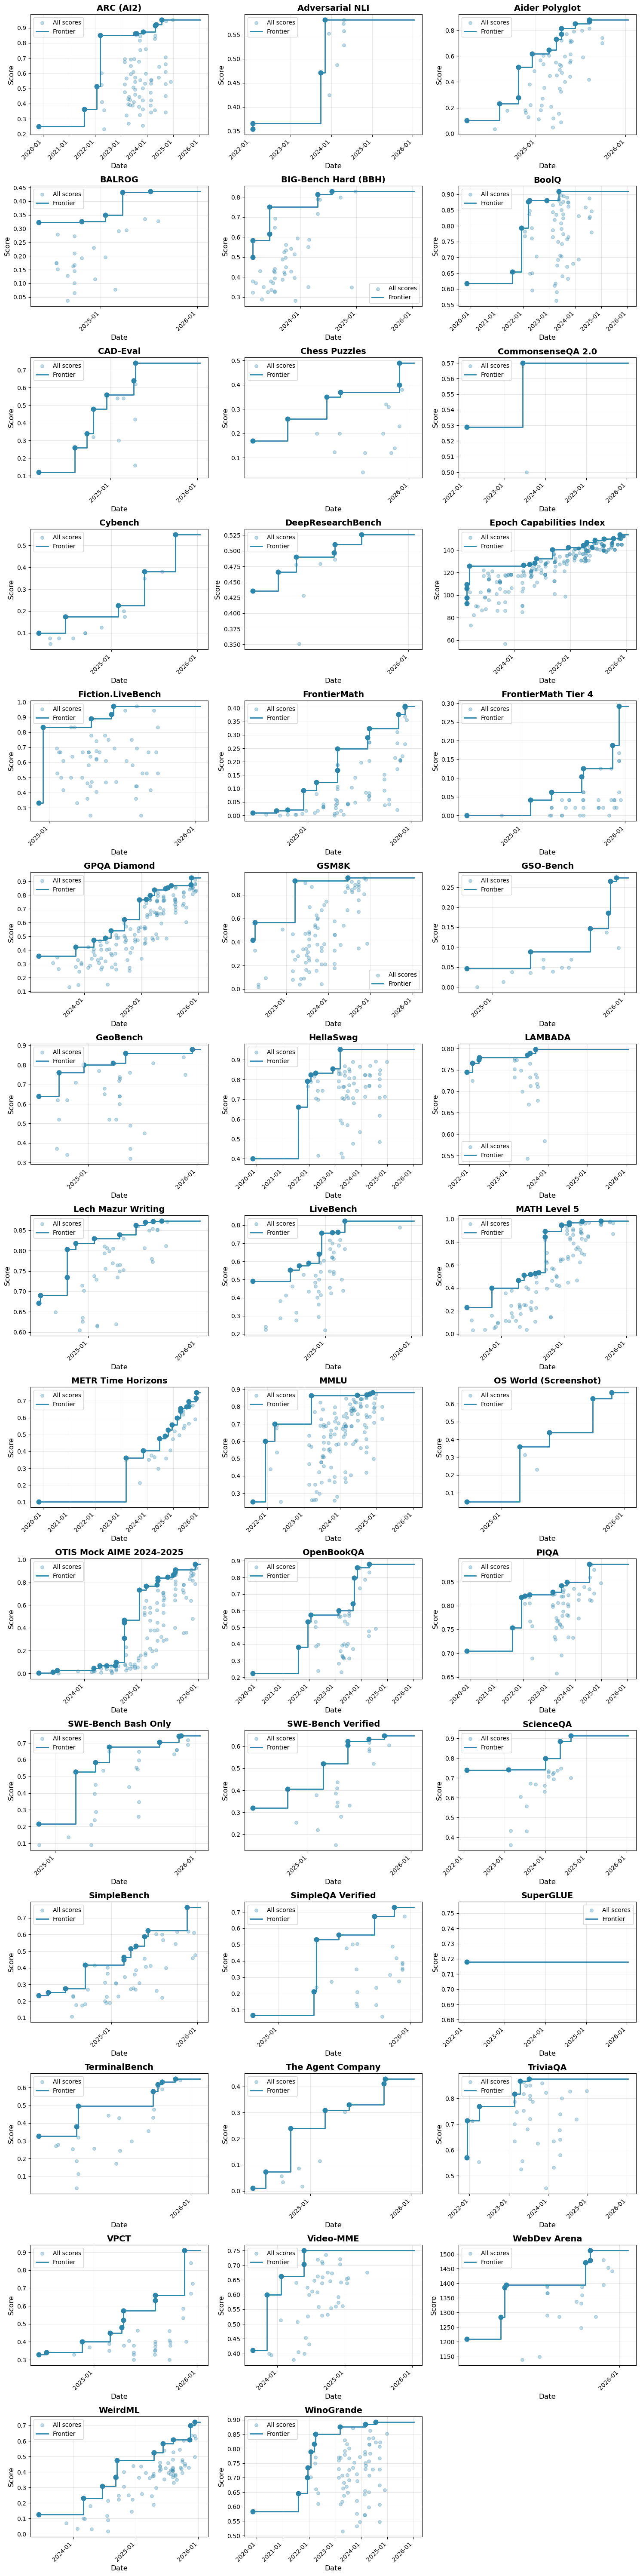

In [136]:
# ============================================================================
# VISUALIZE ALL BENCHMARKS FROM CSV
# ============================================================================

# Extract benchmark matrices from loaded data
benchmark_matrices_csv = extract_benchmark_matrices(df_epochai)

# Print summary
print_benchmark_summary(benchmark_matrices_csv)

# Plot all benchmarks in a grid
print("\n" + "="*80)
print("PLOTTING ALL BENCHMARKS")
print("="*80)

plot_all_benchmarks_grid(df_epochai, cols=3, figsize=(5, 4))

# Scale Benchmarks

In [137]:
import os
import re
import time
import json
from pathlib import Path

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import asyncio
import nest_asyncio

## Fetch benchmark scores from the Scale website

In [138]:
# Allows using asyncio in Jupyter
nest_asyncio.apply()

# Try to import playwright
try:
    from playwright.sync_api import sync_playwright
    PLAYWRIGHT_AVAILABLE = True
except ImportError:
    PLAYWRIGHT_AVAILABLE = False
    print("⚠ Playwright not installed. Run: pip install playwright && playwright install chromium")

BASE_URL = "https://scale.com/leaderboard"

BENCHMARK_SLUGS = {
    "agentic": [
        "rli",
        "mcp_atlas",
        "swe_bench_pro_public",
    ],
    "frontier": [
        "prbench-finance",
        "prbench-legal",
        "humanitys_last_exam",
        "vtb",
        "multinrc",
        "audiomc",
        "multichallenge",
        "enigma_eval",
        "visual_language_understanding",
        "tutorbench",
    ],
}

BENCHMARK_NAME_MAP_SCALE = {
    "rli": "Remote Labor Index",
    "mcp_atlas": "MCP Atlas",
    "swe_bench_pro_public": "SWE-Bench Pro",
    "prbench-finance": "PRBench Finance",
    "prbench-legal": "PRBench Legal",
    "humanitys_last_exam": "Humanity's Last Exam",
    "vtb": "VisualToolBench",
    "multinrc": "MultiNRC",
    "audiomc": "AudioMultiChallenge",
    "multichallenge": "MultiChallenge",
    "enigma_eval": "EnigmaEval",
    "visual_language_understanding": "Visual Task Assessment (VISTA)",
    "tutorbench": "TutorBench",
}

SCALE_SCORE_MAX = {slug: 100 for slug in BENCHMARK_NAME_MAP_SCALE.keys()}

def parse_html_tables(soup: BeautifulSoup, slug: str, category: str, url: str) -> list:
    """Parse HTML tables for leaderboard data."""
    rows = []
    
    tables = soup.find_all("table")
    for table in tables:
        # Get headers
        headers = []
        thead = table.find("thead")
        if thead:
            header_cells = thead.find_all(["th", "td"])
            headers = [h.get_text(strip=True).lower() for h in header_cells]
        
        # Get rows
        tbody = table.find("tbody") or table
        for tr in tbody.find_all("tr"):
            cells = tr.find_all(["td", "th"])
            if len(cells) < 2:
                continue
            
            cell_texts = [c.get_text(strip=True) for c in cells]
            row_data = extract_row_data(headers, cell_texts, slug, category, url)
            if row_data:
                rows.append(row_data)
    
    return rows

def parse_div_layouts(soup: BeautifulSoup, slug: str, category: str, url: str) -> list:
    """Parse div-based layouts for leaderboard data."""
    rows = []
    
    # Common selectors for leaderboard rows
    selectors = [
        "[class*='LeaderboardRow']",
        "[class*='leaderboard-row']",
        "[class*='RankingRow']",
        "[class*='ranking-row']",
        "[class*='TableRow']",
        "[class*='table-row']",
        "div[class*='Row']",
        "[data-testid*='row']",
    ]
    
    for selector in selectors:
        items = soup.select(selector)
        if len(items) > 2:  # Need at least a few rows
            for idx, item in enumerate(items):
                text = item.get_text(" | ", strip=True)
                row_data = parse_row_text(text, idx + 1, slug, category, url)
                if row_data:
                    rows.append(row_data)
            if rows:
                return rows
    
    return rows

def extract_from_text(soup: BeautifulSoup, slug: str, category: str, url: str) -> list:
    """Extract model/score pairs from visible text."""
    rows = []
    
    # Get all text
    text = soup.get_text(" ", strip=True)
    
    # Pattern for model names followed by scores
    # Match common model name patterns with scores
    patterns = [
        # "Model Name 87.5" or "Model Name 87.5%"
        r'((?:Claude|GPT|Gemini|Llama|Mistral|Qwen|DeepSeek|o1|o3|Opus|Sonnet|Haiku)[^\d]{0,50}?)\s+(\d{1,3}\.?\d*)\s*%?',
        # "1. Model Name 87.5"
        r'\d+\.\s*([\w\s\-\.]+?)\s+(\d{1,3}\.?\d*)\s*%?',
    ]
    
    seen = set()
    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        for match in matches:
            model = match[0].strip()
            try:
                score = float(match[1])
            except ValueError:
                continue
            
            # Filter out invalid entries
            if len(model) < 3 or len(model) > 100:
                continue
            if model.lower() in ['the', 'and', 'for', 'with', 'model', 'score']:
                continue
            if score < 0 or score > 100:
                continue
            
            if model not in seen:
                seen.add(model)
                rows.append({
                    "rank": len(rows) + 1,
                    "model": model,
                    "score": score,
                    "stderr": None,
                    "is_new": False,
                    "benchmark_slug": slug,
                    "category": category,
                    "url": url,
                })
    
    return rows

def extract_row_data(headers: list, values: list, slug: str, category: str, url: str) -> dict:
    """Extract row data from table cells."""
    if not values:
        return None
    
    data = dict(zip(headers, values)) if headers else {}
    
    # Find model name
    model = None
    for key in ['model', 'name', 'model name', 'agent']:
        if key in data and data[key]:
            model = data[key]
            break
    
    # If no headers, try first text-like column
    if not model and values:
        for val in values:
            if val and len(val) > 2 and not re.match(r'^[\d\.\-%±]+$', val):
                model = val
                break
    
    # Find score
    score = None
    stderr = None
    for key in ['score', 'accuracy', 'mean', 'average', '%', 'result']:
        if key in data and data[key]:
            score_text = data[key]
            # Try to parse score ± stderr
            match = re.search(r'(\d+\.?\d*)\s*[±]\s*(\d+\.?\d*)', score_text)
            if match:
                score = float(match.group(1))
                stderr = float(match.group(2))
            else:
                match = re.search(r'(\d+\.?\d*)', score_text)
                if match:
                    score = float(match.group(1))
            break
    
    # If no headers, look for numeric values
    if score is None and values:
        for val in values:
            if val:
                match = re.search(r'(\d+\.?\d*)\s*[±]\s*(\d+\.?\d*)', val)
                if match:
                    score = float(match.group(1))
                    stderr = float(match.group(2))
                    break
                elif re.match(r'^\d+\.?\d*%?$', val):
                    score = float(val.replace('%', ''))
                    break
    
    if model and score is not None:
        return {
            "rank": 0,
            "model": model,
            "score": score,
            "stderr": stderr,
            "is_new": False,
            "benchmark_slug": slug,
            "category": category,
            "url": url,
        }
    return None

def parse_row_text(text: str, default_rank: int, slug: str, category: str, url: str) -> dict:
    """Parse a row of text for model and score."""
    # Try score ± stderr pattern
    match = re.search(r'(\d+\.?\d*)\s*[±]\s*(\d+\.?\d*)', text)
    if match:
        score = float(match.group(1))
        stderr = float(match.group(2))
        
        # Model name is before the score
        before = text[:match.start()]
        model = re.sub(r'^\s*\d+[\.\s\|]*', '', before).strip()
        model = re.sub(r'[\|]+$', '', model).strip()
        
        if model and len(model) > 1:
            return {
                "rank": default_rank,
                "model": model,
                "score": score,
                "stderr": stderr,
                "is_new": False,
                "benchmark_slug": slug,
                "category": category,
                "url": url,
            }
    
    # Try simple score pattern
    match = re.search(r'(\d+\.?\d*)%?$', text)
    if match:
        score = float(match.group(1))
        model = text[:match.start()].strip()
        model = re.sub(r'^\s*\d+[\.\s\|]*', '', model).strip()
        
        if model and len(model) > 2 and score <= 100:
            return {
                "rank": default_rank,
                "model": model,
                "score": score,
                "stderr": None,
                "is_new": False,
                "benchmark_slug": slug,
                "category": category,
                "url": url,
            }
    
    return None

def extract_from_next_scripts(soup: BeautifulSoup, slug: str, category: str, url: str) -> list:
    """Extract leaderboard data from Next.js script tags."""
    rows = []
    
    # Find all script tags with Next.js data
    scripts = soup.find_all("script")
    
    for script in scripts:
        if not script.string:
            continue
        
        text = script.string
        
        # Look for self.__next_f.push patterns containing entry data
        if 'self.__next_f.push' not in text:
            continue
        
        # Extract JSON-like entry objects
        # Pattern: "entry":{"model":"xxx","score":xxx,...}
        entry_pattern = r'"entry":\s*\{[^}]+?"model"\s*:\s*"([^"]+)"[^}]+?"score"\s*:\s*([\d.]+)[^}]*\}'
        matches = re.findall(entry_pattern, text)
        
        for model, score in matches:
            try:
                score_val = float(score)
                rows.append({
                    "rank": len(rows) + 1,
                    "model": model,
                    "score": score_val,
                    "stderr": None,
                    "is_new": False,
                    "benchmark_slug": slug,
                    "category": category,
                    "url": url,
                })
            except ValueError:
                continue
        
        if rows:
            return rows
        
        # Alternative: look for model/score pairs in the script
        # Pattern for "model":"name" ... "score":value
        model_pattern = r'"model"\s*:\s*"([^"]+)"'
        score_pattern = r'"score"\s*:\s*([\d.]+)'
        
        models = re.findall(model_pattern, text)
        scores = re.findall(score_pattern, text)
        
        # Only use if we have matching counts and reasonable number
        if len(models) == len(scores) and 3 <= len(models) <= 50:
            for i, (model, score) in enumerate(zip(models, scores)):
                try:
                    score_val = float(score)
                    # Filter out obviously wrong entries
                    if score_val > 0 and len(model) > 2:
                        rows.append({
                            "rank": i + 1,
                            "model": model,
                            "score": score_val,
                            "stderr": None,
                            "is_new": False,
                            "benchmark_slug": slug,
                            "category": category,
                            "url": url,
                        })
                except ValueError:
                    continue
    
    return rows

def parse_leaderboard_from_html_text(soup: BeautifulSoup, slug: str, category: str, url: str) -> list:
    """Parse leaderboard from visible HTML structure."""
    rows = []
    
    # Look for the score entries in the rendered HTML
    # Pattern: model name followed by score like "2.50" or "0.83"
    
    # Find divs that look like leaderboard rows
    # Based on the HTML, look for elements with rank numbers and model names
    
    # Try to find elements with class containing 'gap-3' which wrap each row
    row_divs = soup.select('div.flex.gap-3')
    
    for div in row_divs:
        # Get text content
        text = div.get_text(" ", strip=True)
        
        # Pattern: "rank ModelName score ± stderr" or "rank ModelName score"
        # Example: "1 Manus 1.5 NEW 2.50 ± 0.00"
        
        # Extract rank (first number)
        rank_match = re.match(r'^(\d+)\s+', text)
        if not rank_match:
            continue
        
        rank = int(rank_match.group(1))
        rest = text[rank_match.end():]
        
        # Extract score and optional stderr (last number pattern)
        # Pattern: "X.XX ± X.XX" or "X.XX ± X.XX Calib Err: X.XX" at the end
        score_match = re.search(r'([\d.]+)\s*(?:±\s*([\d.]+))?\s*(?:Calib Err:?\s*[\d.]*)?$', rest)
        if not score_match:
            continue
        
        try:
            score = float(score_match.group(1))
            stderr = float(score_match.group(2)) if score_match.group(2) else None
        except ValueError:
            continue
        
        # Model name is between rank and score
        model_text = rest[:score_match.start()].strip()
        # Clean up model name (remove NEW tag, trailing asterisks, etc.)
        model = re.sub(r'\s*NEW\s*', ' ', model_text).strip()
        model = re.sub(r'\*+\s*$', '', model).strip()  # Remove trailing asterisks
        model = re.sub(r'\s+', ' ', model)
        
        if model and score > 0:
            rows.append({
                "rank": rank,
                "model": model,
                "score": score,
                "stderr": stderr,
                "is_new": 'NEW' in model_text,
                "benchmark_slug": slug,
                "category": category,
                "url": url,
            })
    
    return rows

async def fetch_with_playwright_async(slug: str, category: str) -> list:
    """Fetch leaderboard using Playwright async API."""
    if not PLAYWRIGHT_AVAILABLE:
        print("  Playwright not available")
        return []
    
    from playwright.async_api import async_playwright
    
    url = f"{BASE_URL}/{slug}"
    rows = []
    
    try:
        async with async_playwright() as p:
            browser = await p.chromium.launch(headless=True)
            context = await browser.new_context(
                user_agent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36'
            )
            page = await context.new_page()
            
            print(f"    Loading {url}...")
            await page.goto(url, wait_until="networkidle", timeout=60000)
            await page.wait_for_timeout(5000)  # Wait longer for React to render
            
            html = await page.content()
            await browser.close()
                        
            soup = BeautifulSoup(html, "html.parser")
            
            # Method 1: Extract from Next.js script tags (most reliable)
            rows = extract_from_next_scripts(soup, slug, category, url)
            if rows:
                print(f"    Found {len(rows)} entries from Next.js scripts")
                return rows
            
            # Method 2: Parse from rendered HTML structure
            rows = parse_leaderboard_from_html_text(soup, slug, category, url)
            if rows:
                print(f"    Found {len(rows)} entries from HTML structure")
                return rows
                        
            # Method 3: Parse HTML tables
            rows = parse_html_tables(soup, slug, category, url)
            if rows:
                print(f"    Found {len(rows)} entries from tables")
                return rows
            
            print(f"    No data found for {slug}")
            
    except Exception as e:
        print(f"    Playwright error: {e}")
        import traceback
        traceback.print_exc()
    
    return rows

def fetch_with_playwright(slug: str, category: str) -> list:
    """Wrapper sync pour l'API async."""
    return asyncio.get_event_loop().run_until_complete(
        fetch_with_playwright_async(slug, category)
    )

def extract_organization(model_name: str) -> str:
    """Extract organization from model name."""
    if not model_name:
        return None
    
    model_lower = model_name.lower()
    
    org_patterns = {
        'OpenAI': ['gpt-4', 'gpt-3', 'o1-', 'o3-', 'o1 ', 'o3 ', 'chatgpt', 'openai'],
        'Anthropic': ['claude', 'anthropic', 'opus', 'sonnet', 'haiku'],
        'Google': ['gemini', 'palm', 'bard', 'google'],
        'Meta': ['llama', 'meta'],
        'Mistral': ['mistral', 'mixtral'],
        'DeepSeek': ['deepseek'],
        'Alibaba': ['qwen'],
        'xAI': ['grok'],
    }
    
    for org, patterns in org_patterns.items():
        for pattern in patterns:
            if pattern in model_lower:
                return org
    
    return None

def convert_to_epochai_format(df_scale: pd.DataFrame) -> pd.DataFrame:
    """Convert Scale data to EpochAI format."""
    if df_scale.empty:
        return pd.DataFrame()
    
    records = []
    for _, row in df_scale.iterrows():
        slug = row.get('benchmark_slug', '')
        benchmark_name = BENCHMARK_NAME_MAP_SCALE.get(slug, slug)
        
        raw_score = row.get('score', np.nan)
        max_score = SCALE_SCORE_MAX.get(slug, 100)
        
        if pd.notna(raw_score):
            normalized_score = raw_score / max_score if max_score > 1 else raw_score
        else:
            normalized_score = np.nan
        
        records.append({
            'model_version': row.get('model', ''),
            'score': normalized_score,
            'release_date': None,
            'organization': extract_organization(row.get('model', '')),
            'benchmark': benchmark_name,
            'stderr': row.get('stderr'),
            'source': 'Scale',
        })
    
    return pd.DataFrame(records)

def collect_all_scale_leaderboards() -> pd.DataFrame:
    """Fetch all Scale leaderboards using Playwright."""
    all_rows = []
    
    for category, slugs in BENCHMARK_SLUGS.items():
        for slug in slugs:
            print(f"Fetching {category}/{slug} ...")
            rows = fetch_with_playwright(slug, category)
            if rows:
                print(f"  Found {len(rows)} models")
                all_rows.extend(rows)
            else:
                print(f"  No data found")
            time.sleep(2)  # Be polite
    
    return pd.DataFrame(all_rows)

def load_scale_benchmarks() -> pd.DataFrame:
    """Load Scale benchmarks in EpochAI-compatible format."""
    print("="*80)
    print("LOADING SCALE LEADERBOARD DATA (using Playwright)")
    print("="*80)
    
    if not PLAYWRIGHT_AVAILABLE:
        print("\n⚠ Playwright not installed.")
        print("  Install with: pip install playwright && playwright install chromium")
        return pd.DataFrame()
    
    df_raw = collect_all_scale_leaderboards()
    
    if df_raw.empty:
        print("\nNo data collected from Scale leaderboards")
        return pd.DataFrame()
    
    # Save raw data
    raw_output = Path("benchmark_data_processed/scale_seal_leaderboards_raw.csv")
    df_raw.to_csv(raw_output, index=False)
    print(f"\nSaved raw data: {len(df_raw)} rows to {raw_output}")
    
    # Convert to standard format
    df_formatted = convert_to_epochai_format(df_raw)
    
    print("\n" + "="*80)
    print("SCALE BENCHMARK SUMMARY")
    print("="*80)
    print(f"Total records: {len(df_formatted)}")
    print(f"Benchmarks: {df_formatted['benchmark'].nunique()}")
    print(f"Unique models: {df_formatted['model_version'].nunique()}")
    
    return df_formatted

async def check_missing_scale_benchmarks():
    """Check if any Scale benchmarks are missing from BENCHMARK_SLUGS."""
    if not PLAYWRIGHT_AVAILABLE:
        print("⚠ Playwright required for this check")
        return
    
    from playwright.async_api import async_playwright
    
    # Get all known slugs
    known_slugs = set()
    for slugs in BENCHMARK_SLUGS.values():
        known_slugs.update(slugs)
        
    print("="*60)
    print("CHECKING FOR MISSING SCALE BENCHMARKS")
    print("="*60)
    
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        
        await page.goto(BASE_URL, wait_until="networkidle", timeout=60000)
        await page.wait_for_timeout(3000)
        
        # Extract all benchmark links
        links = await page.eval_on_selector_all(
            'a[href*="/leaderboard/"]',
            'els => els.map(e => e.href)'
        )
        
        await browser.close()
    
    # Parse slugs from URLs
    found_slugs = set()
    for link in links:
        match = re.search(r'/leaderboard/([^/?#]+)', link)
        if match:
            found_slugs.add(match.group(1))
    
    # Identify missing benchmarks
    missing = found_slugs - known_slugs
    
    if missing:
        print(f"\n⚠️  {len(missing)} BENCHMARK(S) FOUND ON SITE BUT MISSING FROM BENCHMARK_SLUGS:")
        for slug in sorted(missing):
            print(f"    - {slug}")
        print(f"\n→ Add relevant ones to BENCHMARK_SLUGS if needed.")
    else:
        print(f"\n✅ All non-safety benchmarks from site are in BENCHMARK_SLUGS ({len(known_slugs)} benchmarks)")
    
    print(f"\nBenchmarks on site (excl. safety): {len(found_slugs)}")
    print(f"Benchmarks configured: {len(known_slugs)}")

# Run the check
asyncio.get_event_loop().run_until_complete(check_missing_scale_benchmarks())

CHECKING FOR MISSING SCALE BENCHMARKS

⚠️  5 BENCHMARK(S) FOUND ON SITE BUT MISSING FROM BENCHMARK_SLUGS:
    - fortress
    - humanitys_last_exam_text_only
    - mask
    - propensitybench
    - swe_bench_pro_commercial

→ Add relevant ones to BENCHMARK_SLUGS if needed.

Benchmarks on site (excl. safety): 18
Benchmarks configured: 13


In [139]:
# ---- Execute ----
df_scale = load_scale_benchmarks()

if not df_scale.empty:
    print("\n" + "="*80)
    print("SAMPLE DATA (Scale Benchmarks)")
    print("="*80)
    print(df_scale.head(15))

output_path = Path("benchmark_data_processed/scale_benchmarks.csv")
df_scale.to_csv(output_path, index=False)
print(f"\n✓ Saved formatted Scale data to {output_path}")

LOADING SCALE LEADERBOARD DATA (using Playwright)
Fetching agentic/rli ...
    Loading https://scale.com/leaderboard/rli...
    Found 9 entries from HTML structure
  Found 9 models
Fetching agentic/mcp_atlas ...
    Loading https://scale.com/leaderboard/mcp_atlas...
    Found 19 entries from HTML structure
  Found 19 models
Fetching agentic/swe_bench_pro_public ...
    Loading https://scale.com/leaderboard/swe_bench_pro_public...
    Found 16 entries from HTML structure
  Found 16 models
Fetching frontier/prbench-finance ...
    Loading https://scale.com/leaderboard/prbench-finance...
    Found 23 entries from HTML structure
  Found 23 models
Fetching frontier/prbench-legal ...
    Loading https://scale.com/leaderboard/prbench-legal...
    Found 23 entries from HTML structure
  Found 23 models
Fetching frontier/humanitys_last_exam ...
    Loading https://scale.com/leaderboard/humanitys_last_exam...
    Found 41 entries from HTML structure
  Found 41 models
Fetching frontier/vtb ...
   

# ARC-AGI Benchmarks

In [140]:
# ============================================================================
# ARC-AGI LEADERBOARD DATA
# ============================================================================
# Scrapes or loads ARC-AGI-1 and ARC-AGI-2 leaderboard data from arcprize.org
# 
# Sources: arcprize.org/leaderboard

# ============================================================================
# LIVE SCRAPING FUNCTION
# ============================================================================

def _parse_arc_row(text, benchmark_version):
    """Parse a leaderboard row into a record dict."""
    import re
    
    # Skip human baseline
    if 'human' in text.lower():
        return None
    
    # Split by tab characters (table columns)
    parts = [p.strip() for p in text.split('\t')]
    
    # Expected columns based on arcprize.org structure:
    # 0: Model Name
    # 1: Organization  
    # 2: System Type (can be N/A)
    # 3: ARC-AGI-1 Score (%)
    # 4: ARC-AGI-2 Score (%)
    # 5: Cost
    # 6: Other
    
    if len(parts) < 5:
        return None
    
    # Model name is first column
    model_name = re.sub(r'^[\d#]+\.?\s*', '', parts[0])
    
    # Get system type from column 2
    system_type = parts[2] if len(parts) > 2 else ""
    
    # Skip custom architectures
    if 'custom' in system_type.lower():
        return None
    
    # Get score from correct column index
    score_col = 3 if benchmark_version == "ARC-AGI-1" else 4
    score_str = parts[score_col] if len(parts) > score_col else "N/A"
    
    # Skip if N/A
    if 'N/A' in score_str or not re.search(r'\d', score_str):
        return None
    
    # Extract percentage value
    score_match = re.search(r'(\d+\.?\d*)%?', score_str)
    if not score_match:
        return None
    score = float(score_match.group(1)) / 100.0
    
    # Extract cost from column 5 or search in text
    cost = None
    if len(parts) > 5:
        cost_match = re.search(r'\$(\d+[\d,]*\.?\d*)', parts[5])
        if cost_match:
            cost = float(cost_match.group(1).replace(',', ''))
    
    # Infer organization from column 1 or text
    org = 'Other'
    org_text = parts[1].lower() if len(parts) > 1 else text.lower()
    if 'openai' in org_text:
        org = 'OpenAI'
    elif 'anthropic' in org_text:
        org = 'Anthropic'
    elif 'google' in org_text or 'deepmind' in org_text:
        org = 'Google'
    elif 'xai' in org_text:
        org = 'xAI'
    elif 'deepseek' in org_text:
        org = 'DeepSeek'
    elif 'meta' in org_text:
        org = 'Meta'
    elif 'mistral' in org_text:
        org = 'Mistral'
    
    return {
        'model_version': model_name,
        'score': score,
        'release_date': None,
        'organization': org,
        'benchmark': benchmark_version,
        'cost_per_task': cost
    }

async def scrape_arc_agi_leaderboard_async():
    """Scrape ARC-AGI leaderboard using async Playwright."""
    from playwright.async_api import async_playwright
    
    all_records = []
    
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        
        await page.goto("https://arcprize.org/leaderboard", wait_until="networkidle")
        await asyncio.sleep(4)
        
        # Extract table rows once - both scores are in same row
        rows = await page.query_selector_all("table tbody tr")
        print(f"Found {len(rows)} rows")
        
        for row in rows:
            text = await row.inner_text()
            
            # Parse for ARC-AGI-1
            record1 = _parse_arc_row(text, "ARC-AGI-1")
            if record1:
                all_records.append(record1)
            
            # Parse for ARC-AGI-2
            record2 = _parse_arc_row(text, "ARC-AGI-2")
            if record2:
                all_records.append(record2)
        
        await browser.close()
    
    return pd.DataFrame(all_records)

# Run scraper
df_arc_agi = asyncio.get_event_loop().run_until_complete(scrape_arc_agi_leaderboard_async())

# Filter out human baselines
df_arc_agi = df_arc_agi[~df_arc_agi['model_version'].str.lower().str.contains('human', na=False)].copy()

# Filter out models more expensive than the human panel ($17 per task)
df_arc_agi = df_arc_agi[(df_arc_agi['cost_per_task'].isna()) | (df_arc_agi['cost_per_task'] <= 17)]

# Display summary
print(f"\n{'='*60}")
print("ARC-AGI LEADERBOARD SUMMARY")
print(f"{'='*60}")
for bench in df_arc_agi['benchmark'].unique():
    subset = df_arc_agi[df_arc_agi['benchmark'] == bench]
    print(f"\n{bench}:")
    print(f"  Entries: {len(subset)}")
    print(f"  Max score: {subset['score'].max():.1%}")
    top_idx = subset['score'].idxmax()
    print(f"  Top model: {subset.loc[top_idx, 'model_version']}")

output_path = Path("benchmark_data_processed/arc_agi_benchmarks.csv")
df_arc_agi.to_csv(output_path, index=False)
print(f"\n✓ Saved formatted ARC-AGI data to {output_path}")

Found 116 rows

ARC-AGI LEADERBOARD SUMMARY

ARC-AGI-1:
  Entries: 103
  Max score: 90.5%
  Top model: GPT-5.2 Pro (X-High)

ARC-AGI-2:
  Entries: 105
  Max score: 54.2%
  Top model: GPT-5.2 Pro (High)

✓ Saved formatted ARC-AGI data to benchmark_data_processed/arc_agi_benchmarks.csv


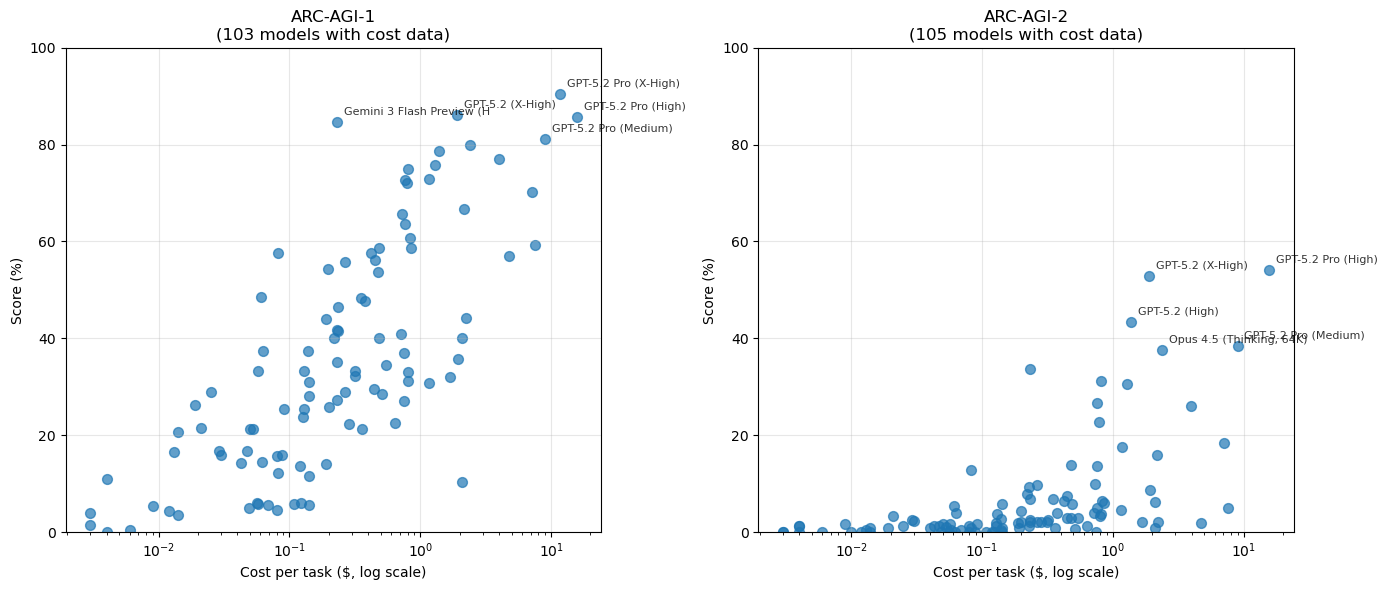


Top 10 by score (with cost):

ARC-AGI-1:
                model_version score cost_per_task
         GPT-5.2 Pro (X-High) 90.5%        $11.65
             GPT-5.2 (X-High) 86.2%          $1.9
           GPT-5.2 Pro (High) 85.7%        $15.72
Gemini 3 Flash Preview (High) 84.7%         $0.23
         GPT-5.2 Pro (Medium) 81.2%         $8.99
     Opus 4.5 (Thinking, 64K) 80.0%          $2.4
               GPT-5.2 (High) 78.7%         $1.39
             Grok 4 (Refine.) 77.1%         $3.97
     Opus 4.5 (Thinking, 32K) 75.8%         $1.29
                 Gemini 3 Pro 75.0%         $0.81

ARC-AGI-2:
                model_version score cost_per_task
           GPT-5.2 Pro (High) 54.2%        $15.72
             GPT-5.2 (X-High) 52.9%          $1.9
               GPT-5.2 (High) 43.3%         $1.39
         GPT-5.2 Pro (Medium) 38.5%         $8.99
     Opus 4.5 (Thinking, 64K) 37.6%          $2.4
Gemini 3 Flash Preview (High) 33.6%         $0.23
                 Gemini 3 Pro 31.1%         $0

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, bench in enumerate(["ARC-AGI-1", "ARC-AGI-2"]):
    ax = axes[idx]
    subset = df_arc_agi[(df_arc_agi['benchmark'] == bench) & (df_arc_agi['cost_per_task'].notna())]
    
    ax.scatter(subset['cost_per_task'], subset['score'] * 100, alpha=0.7, s=50)
    
    # Label top performers
    top_n = subset.nlargest(5, 'score')
    for _, row in top_n.iterrows():
        ax.annotate(row['model_version'][:25], 
                    (row['cost_per_task'], row['score'] * 100),
                    fontsize=8, alpha=0.8,
                    xytext=(5, 5), textcoords='offset points')
    
    ax.set_xscale('log')
    ax.set_xlabel('Cost per task ($, log scale)')
    ax.set_ylabel('Score (%)')
    ax.set_title(f'{bench}\n({len(subset)} models with cost data)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Also print a quick table
print("\nTop 10 by score (with cost):")
for bench in ["ARC-AGI-1", "ARC-AGI-2"]:
    print(f"\n{bench}:")
    subset = df_arc_agi[(df_arc_agi['benchmark'] == bench) & (df_arc_agi['cost_per_task'].notna())]
    top = subset.nlargest(10, 'score')[['model_version', 'score', 'cost_per_task']]
    top['score'] = (top['score'] * 100).round(1).astype(str) + '%'
    top['cost_per_task'] = '$' + top['cost_per_task'].round(2).astype(str)
    print(top.to_string(index=False))

# RAND Benchmarks

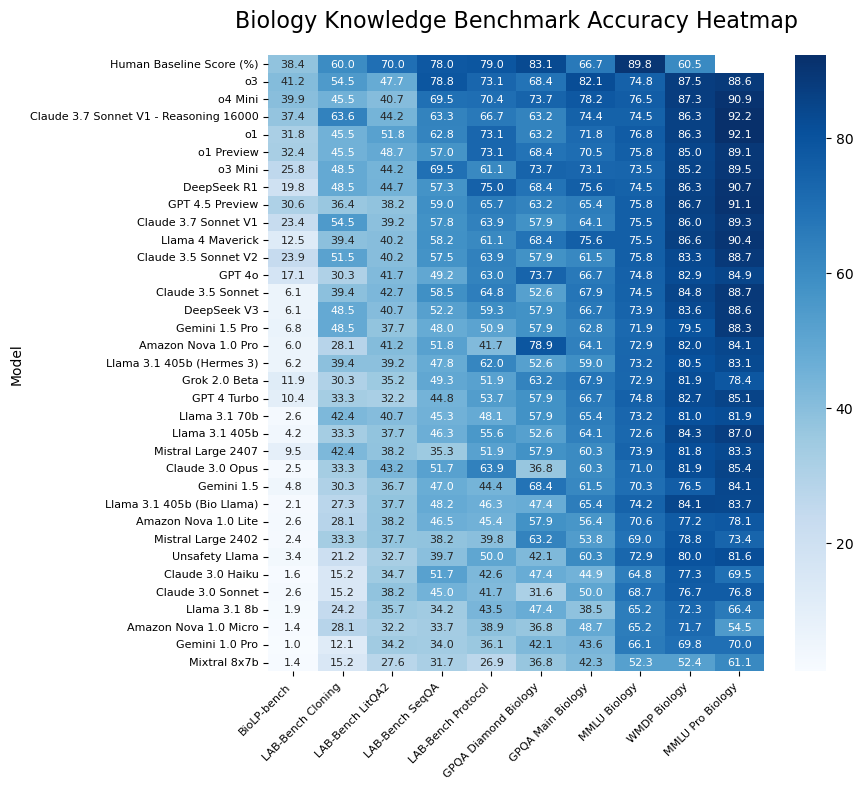

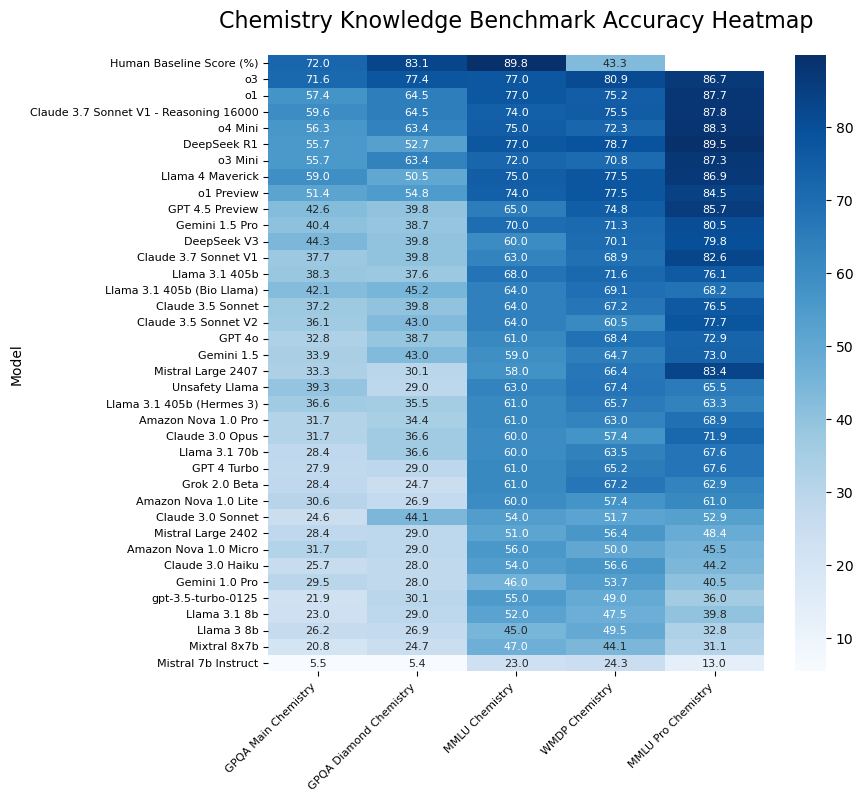

In [142]:
import seaborn as sns

# ---------------------------------------------------------
# 1. Load the Dataset
# ---------------------------------------------------------

# Read the CSV data
df_rand = pd.read_csv("benchmark_data_RAND/benchmark_scores_RAND.csv")

# ---------------------------------------------------------
# 2. Preprocess Data
# ---------------------------------------------------------
# Filter out the "Human Baseline Description" row for numerical analysis
df_rand_numeric = df_rand[df_rand["Model"] != "Human Baseline Description"].copy()

# Set Model as Index
df_rand_numeric.set_index("Model", inplace=True)

# Convert columns to numeric, forcing "N/A" to NaN
df_rand_numeric = df_rand_numeric.apply(pd.to_numeric, errors='coerce')

# Hide specific models by name
df_rand_numeric = df_rand_numeric.drop(['GPT 4', 'Llama 3 70b', 'Llama 4 Scout'])

# Separate Biology and Chemistry columns
bio_cols = [c for c in df_rand_numeric.columns if "Bio:" in c]
chem_cols = [c for c in df_rand_numeric.columns if "Chem:" in c]

# ---------------------------------------------------------
# 3. Plotting Function
# ---------------------------------------------------------
def plot_heatmap(data, columns, title):
    # Subset the data
    subset = data[columns].copy()
    
    # Rename columns for cleaner labels (remove prefixes)
    subset.columns = [c.replace("Bio: ", "").replace("Chem: ", "") for c in subset.columns]
    
    # Separate Human Baseline score row and Model rows
    baseline_row = subset.loc[["Human Baseline Score (%)"]]
    models_only = subset.drop("Human Baseline Score (%)").dropna(how='all')
    
    # Sort models by Average Score (descending)
    models_only['Avg'] = models_only.mean(axis=1)
    models_only = models_only.sort_values('Avg', ascending=False)
    models_only = models_only.drop('Avg', axis=1)
    
    # Recombine: Baseline on top, followed by sorted models
    plot_data = pd.concat([baseline_row, models_only])
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(plot_data, annot=True, fmt=".1f", cmap="Blues", 
                linewidths=0, annot_kws={"size": 8}, ax=ax)

    # Make the background of the axes and the figure transparent
    ax.set_facecolor((0, 0, 0, 0))
    fig.patch.set_alpha(0.0)
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.yticks(np.arange(len(plot_data)) + 0.5, plot_data.index)
    
    # Save with transparent=True to preserve the transparency in the output file
    #plt.savefig(f"{title}.png", transparent=True, bbox_inches='tight')
    plt.show()

# ---------------------------------------------------------
# 4. Generate Plots
# ---------------------------------------------------------
# Plot Biology Benchmarks
plot_heatmap(df_rand_numeric, bio_cols, "Biology Knowledge Benchmark Accuracy Heatmap")

# Plot Chemistry Benchmarks
plot_heatmap(df_rand_numeric, chem_cols, "Chemistry Knowledge Benchmark Accuracy Heatmap")

In [143]:
# ============================================================================
# EXPORT RAND BENCHMARKS
# ============================================================================

def convert_rand_to_epochai_format(df_rand: pd.DataFrame) -> pd.DataFrame:
    """
    Convert RAND benchmark data to EpochAI-compatible format.
    
    Args:
        df_rand: DataFrame loaded from benchmark_scores_RAND.csv
    
    Returns:
        DataFrame with columns: model_version, score, release_date, 
        organization, benchmark, stderr, source
    """
    # Filter out non-numeric rows and Human Baseline Score
    df_numeric = df_rand[
        (df_rand["Model"] != "Human Baseline Description") &
        (df_rand["Model"] != "Human Baseline Score (%)")
    ].copy()
    
    df_numeric.set_index("Model", inplace=True)
    df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
    
    # Separate Biology and Chemistry columns
    bio_cols = [c for c in df_numeric.columns if "Bio:" in c]
    chem_cols = [c for c in df_numeric.columns if "Chem:" in c]
    
    records = []
    
    # Process each model
    for model_name, row in df_numeric.iterrows():
        # Skip empty rows
        if row.isna().all():
            continue
        
        # Infer organization from model name
        org = extract_organization(model_name)
        
        # Process Biology benchmarks
        for col in bio_cols:
            score = row[col]
            if pd.notna(score):
                # Extract benchmark name (remove "Bio: " prefix)
                benchmark_name = col.replace("Bio: ", "")
                
                # Normalize score (RAND uses 0-100 scale)
                normalized_score = score / 100.0
                
                records.append({
                    'model_version': model_name,
                    'score': normalized_score,
                    'release_date': None,
                    'organization': org,
                    'benchmark': benchmark_name,
                    'stderr': None,
                    'source': 'RAND',
                })
        
        # Process Chemistry benchmarks
        for col in chem_cols:
            score = row[col]
            if pd.notna(score):
                # Extract benchmark name (remove "Chem: " prefix)
                benchmark_name = col.replace("Chem: ", "")
                
                # Normalize score (RAND uses 0-100 scale)
                normalized_score = score / 100.0 if score > 1 else score
                
                records.append({
                    'model_version': model_name,
                    'score': normalized_score,
                    'release_date': None,
                    'organization': org,
                    'benchmark': benchmark_name,
                    'stderr': None,
                    'source': 'RAND',
                })
    
    return pd.DataFrame(records)

# Load RAND data
df_rand = pd.read_csv("benchmark_data_RAND/benchmark_scores_RAND.csv")

# Hide specific models by name
df_rand = df_rand[~df_rand['Model'].isin(['GPT 4', 'Llama 3 70b', 'Llama 4 Scout'])]

# Convert to standard format
df_rand_formatted = convert_rand_to_epochai_format(df_rand)

# Save RAND benchmarks
output_path = Path("benchmark_data_processed/rand_benchmarks.csv")
df_rand_formatted.to_csv(output_path, index=False)

print("="*80)
print("RAND BENCHMARK EXPORT SUMMARY")
print("="*80)
print(f"Records: {len(df_rand_formatted)}")
print(f"Unique benchmarks: {df_rand_formatted['benchmark'].nunique()}")
print(f"Unique models: {df_rand_formatted['model_version'].nunique()}")
print(f"With release dates: {df_rand_formatted['release_date'].notna().sum()}")
print(f"\nBenchmarks:")
for bench in sorted(df_rand_formatted['benchmark'].unique()):
    count = len(df_rand_formatted[df_rand_formatted['benchmark'] == bench])
    print(f"  - {bench}: {count} records")

print(f"\n✓ Saved to {output_path}")

RAND BENCHMARK EXPORT SUMMARY
Records: 525
Unique benchmarks: 15
Unique models: 37
With release dates: 0

Benchmarks:
  - BioLP-bench: 34 records
  - GPQA Diamond Biology: 34 records
  - GPQA Diamond Chemistry: 37 records
  - GPQA Main Biology: 34 records
  - GPQA Main Chemistry: 37 records
  - LAB-Bench Cloning: 34 records
  - LAB-Bench LitQA2: 34 records
  - LAB-Bench Protocol: 34 records
  - LAB-Bench SeqQA: 34 records
  - MMLU Biology: 34 records
  - MMLU Chemistry: 37 records
  - MMLU Pro Biology: 34 records
  - MMLU Pro Chemistry: 37 records
  - WMDP Biology: 34 records
  - WMDP Chemistry: 37 records

✓ Saved to benchmark_data_processed/rand_benchmarks.csv


# Processing and export

## Fill missing dates

In [144]:
# ============================================================================
# MERGE ALL BENCHMARKS
# ============================================================================

# Prepare all DataFrames in one pass
dataframes_to_merge = []
common_columns = ['model_version', 'score', 'release_date', 'organization', 'benchmark', 'stderr', 'source']

for df, source_name in [
    (df_epochai, 'EpochAI'),
    (df_scale, 'Scale'),
    (df_arc_agi, 'ARC-AGI'),
    (df_rand_formatted, 'RAND'),
]:
    df_prep = df.copy()
    
    # Add source column if missing
    if 'source' not in df_prep.columns:
        df_prep['source'] = source_name
    
    # Ensure all common columns exist (add as None if missing)
    for col in common_columns:
        if col not in df_prep.columns:
            df_prep[col] = None
    
    # Select only common columns (now they all exist)
    df_prep = df_prep[common_columns]
    dataframes_to_merge.append(df_prep)

# Merge all at once
df_all_benchmarks = pd.concat(dataframes_to_merge, ignore_index=True, sort=False)

# Remove duplicates if any (same model, benchmark, score)
before_dedup = len(df_all_benchmarks)
df_all_benchmarks = df_all_benchmarks.drop_duplicates(
    subset=['model_version', 'benchmark', 'score'],
    keep='first'
)
after_dedup = len(df_all_benchmarks)

if before_dedup != after_dedup:
    print(f"Removed {before_dedup - after_dedup} duplicate records")

print("="*80)
print("ALL BENCHMARKS MERGED")
print("="*80)
print(f"EpochAI records: {len(df_epochai)}")
print(f"Scale records: {len(df_scale)}")
print(f"ARC-AGI records: {len(df_arc_agi)}")
print(f"RAND records: {len(df_rand_formatted)}")
print(f"Total records: {len(df_all_benchmarks)}")
print(f"Total benchmarks: {df_all_benchmarks['benchmark'].nunique()}")
print(f"Total unique models: {df_all_benchmarks['model_version'].nunique()}")

ALL BENCHMARKS MERGED
EpochAI records: 2626
Scale records: 392
ARC-AGI records: 208
RAND records: 525
Total records: 3751
Total benchmarks: 74
Total unique models: 969


/var/folders/ct/fw960pjx4l1d652ll2y6zk5c0000gp/T/ipykernel_65522/2631246591.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_benchmarks = pd.concat(dataframes_to_merge, ignore_index=True, sort=False)


In [154]:
# ============================================================================
# PARSE DATES FROM MODEL NAMES AND FILL MISSING RELEASE DATES
# ============================================================================

import re
from datetime import date

def parse_date_from_model_name(model_name: str) -> date:
    """
    Try to extract a release date from the model name.
    Supports formats like:
    - 2025-08-07
    - 20250929
    - (December 2024)
    - (April 2025)
    - (June 2025)
    - (March 2025)
    """
    if not model_name:
        return None
    
    # Pattern 1: YYYY-MM-DD format (e.g., "2025-08-07")
    match = re.search(r'(\d{4})-(\d{2})-(\d{2})', model_name)
    if match:
        try:
            return date(int(match.group(1)), int(match.group(2)), int(match.group(3)))
        except ValueError:
            pass
    
    # Pattern 2: YYYYMMDD format (e.g., "20250929")
    match = re.search(r'(\d{4})(\d{2})(\d{2})', model_name)
    if match:
        try:
            year, month, day = int(match.group(1)), int(match.group(2)), int(match.group(3))
            if 2020 <= year <= 2030 and 1 <= month <= 12 and 1 <= day <= 31:
                return date(year, month, day)
        except ValueError:
            pass
    
    # Pattern 3: Month Year format (e.g., "(December 2024)", "(April 2025)")
    month_map = {
        'january': 1, 'february': 2, 'march': 3, 'april': 4,
        'may': 5, 'june': 6, 'july': 7, 'august': 8,
        'september': 9, 'october': 10, 'november': 11, 'december': 12
    }
    match = re.search(r'\(?(january|february|march|april|may|june|july|august|september|october|november|december)\s+(\d{4})\)?', 
                      model_name, re.IGNORECASE)
    if match:
        try:
            month = month_map[match.group(1).lower()]
            year = int(match.group(2))
            # Use the 1st of the month as default
            return date(year, month, 1)
        except (ValueError, KeyError):
            pass
    
    # Pattern 4: preview-MM-DD format (e.g., "preview-06-05")
    match = re.search(r'preview-(\d{2})-(\d{2})', model_name)
    if match:
        try:
            month, day = int(match.group(1)), int(match.group(2))
            # Assume 2025 for recent previews
            if 1 <= month <= 12 and 1 <= day <= 31:
                return date(2025, month, day)
        except ValueError:
            pass
    
    return None

# Test the parsing function
print("="*80)
print("TESTING DATE PARSING FROM MODEL NAMES")
print("="*80)

test_models = [
    'claude-sonnet-4-5-20250929',
    'gpt-5-2025-08-07',
    'o1 (December 2024)',
    'o3 (high) (April 2025)',
    'gemini-2.5-pro-preview-06-05',
    'gpt-4o-2024-11-20',
]

for model in test_models:
    parsed = parse_date_from_model_name(model)
    print(f"  '{model}' -> {parsed}")

# ============================================================================
# FILL DATES FROM MODEL NAMES
# ============================================================================

print("\n" + "="*80)
print("FILLING DATES FROM MODEL NAMES")
print("="*80)

# Count missing dates before
missing_before = df_all_benchmarks['release_date'].isna().sum()
print(f"\nMissing release dates before: {missing_before}")

# Fill dates parsed from model names
filled_from_name = 0
for idx, row in df_all_benchmarks.iterrows():
    if pd.isna(row['release_date']):
        parsed_date = parse_date_from_model_name(row['model_version'])
        if parsed_date:
            df_all_benchmarks.at[idx, 'release_date'] = parsed_date
            filled_from_name += 1

print(f"Filled {filled_from_name} dates from model name parsing")

# Count missing dates after
missing_after = df_all_benchmarks['release_date'].isna().sum()
print(f"Missing release dates after: {missing_after}")

# ============================================================================
# MANUAL DATE MAPPING FOR REMAINING MODELS
# ============================================================================

# Define manual mappings for known models
MANUAL_DATE_MAP = {
    'ada': date(2020, 6, 22),
    'Alpaca (7B)': date(2023, 3, 13),
    'Anthropic-LM v4-s3 (52B)': date(2023, 4, 12),
    'AquilaChat2 34B': date(2023, 10, 12),
    'Arctic Instruct': date(2024, 4, 24),
    'ARChitects': date(2024, 11, 3),
    'babbage': date(2020, 6, 22),
    'Baichuan2-Chat 13B (8-shot)': date(2023, 9, 6),
    'Baichuan2-Chat 7B (8-shot)': date(2023, 9, 20),
    'BAN': date(2022, 9, 20),
    'Chameleon (ChatGPT)': date(2024, 5, 16),
    'Chameleon (GPT-4)': date(2024, 5, 16),
    'Chat-UniVi': date(2023, 11, 14),
    'ChatGLM 2-6B (base)': date(2023, 6, 24),
    'ChatGPT': None, # Ambiguous
    'ChatGPT agent': date(2025, 7, 17),
    'Chinese-Alpaca-Plus-13B': date(2023, 5, 9),
    'Claude 3.0 Haiku': date(2024, 3, 7),  # Anthropic - RAND
    'Claude 3.0 Opus': date(2024, 2, 29),
    'Claude 3.0 Sonnet': date(2024, 2, 29),
    'Claude 3.5 Sonnet': date(2024, 6, 20),
    'Claude 3.5 Sonnet V2': date(2024, 10, 22),
    'Claude 3.7 Sonnet V1': date(2025, 2, 19),
    'Claude 3.7 Sonnet V1 - Reasoning 16000': date(2025, 2, 19),
    'Claude 3 Opus': date(2024, 2, 29),
    'Claude 3.7 Sonnet (Thinking)': date(2025, 2, 24),
    'Claude-3.7-Sonnet-thinking': date(2025, 2, 24),
    'Claude 3.7 Sonnet Thinking (Feb 2025)': date(2025, 2, 24),
    'Claude 3.7': date(2025, 2, 24),
    'Claude 3.7 (16K)': date(2025, 2, 24),
    'Claude 3.7 (1K)': date(2025, 2, 24),
    'Claude 3.7 (8K)': date(2025, 2, 24),
    'claude-37-sonnet-thinking': date(2025, 2, 24),
    'claude-4-5-haiku': date(2025, 10, 15),
    'Claude Haiku 4.5': date(2025, 10, 15),
    'Claude Haiku 4.5 (Thinking 16K)': date(2025, 10, 15),
    'Claude Haiku 4.5 (Thinking 1K)': date(2025, 10, 15),
    'Claude Haiku 4.5 (Thinking 32K)': date(2025, 10, 15),
    'Claude Haiku 4.5 (Thinking 8K)': date(2025, 10, 15),
    'Claude Sonnet 4.5': date(2025, 9, 29),
    'Claude Sonnet 4.5 (Thinking 16K)': date(2025, 9, 29),
    'Claude Sonnet 4.5 (Thinking 1K)': date(2025, 9, 29),
    'Claude Sonnet 4.5 (Thinking 32K)': date(2025, 9, 29),
    'Claude Sonnet 4.5 (Thinking 8K)': date(2025, 9, 29),
    'claude-4-5-Sonnet': date(2025, 9, 29),
    'claude-4-5-sonnet': date(2025, 9, 29),
    'claude-4-Sonnet': date(2025, 5, 22),
    'claude-instant-1.1': date(2023, 8, 9),
    'Claude Opus 4': date(2025, 5, 22),
    'Claude Opus 4 (Thinking)': date(2025, 5, 22),
    'Claude Opus 4 (Thinking 16K)': date(2025, 5, 22),
    'Claude Opus 4 (Thinking 1K)': date(2025, 5, 22),
    'Claude Opus 4 (Thinking 8K)': date(2025, 5, 22),
    'Claude Sonnet 4': date(2025, 5, 22),
    'Claude Sonnet 4 (Thinking 16K)': date(2025, 5, 22),
    'Claude Sonnet 4 (Thinking 1K)': date(2025, 5, 22),
    'Claude Sonnet 4 (Thinking 8K)': date(2025, 5, 22),
    'claude-sonnet-4': date(2025, 5, 22),
    'Claude Sonnet 4 (Thinking)': date(2025, 5, 22),
    'claude-sonnet-4-thinking': date(2025, 5, 22),
    'code-cushman-001 (12B)': date(2021, 7, 7),
    'code-davinci-002': date(2022, 3, 15),
    'Codex Mini (Latest)': date(2025, 4, 16),
    'Cohere Command beta (52.4B)': date(2023, 3, 1),
    'Cohere Command beta (6.1B)': date(2023, 3, 1),
    'CoMD (Vicuna-7B)': date(2023, 11, 14),
    'CoT ChatGPT': date(2023, 4, 19),
    'CoT GPT-3 (AE)': date(2022, 9, 20),
    'CoT GPT-3 (ALE)': date(2022, 9, 20),
    'CoT GPT-3 + Doc': date(2023, 8, 1),
    'CoT GPT-4': date(2023, 4, 19),
    'CoT UnifiedQA': date(2022, 9, 20),
    'curie': date(2020, 6, 22),
    'davinci': date(2020, 5, 28),
    'davinci-002': date(2022, 3, 15),
    'DBRX Instruct': date(2024, 3, 27),
    'DDCoT (ChatGPT)': date(2023, 10, 25),
    'DDCoT (GPT-3)': date(2023, 10, 25),
    'DDCoT (MiniGPT-4)': date(2023, 10, 25),
    'DDCoT (T5)': date(2023, 10, 25),
    'deepinfra/Qwen3-Next-80B-A3B-Instruct': date(2025, 9, 11),
    'DeepSeek LLM Chat (67B)': date(2024, 1, 5),
    'Deepseek-R1': date(2025, 1, 20),
    'Deepseek R1': date(2025, 1, 20),
    'Deepseek R1 (05/28)': date(2025, 5, 28),
    'DeepSeek R1 (Jan 2025)': date(2025, 1, 20),
    'DeepSeek-R1-0528': date(2025, 5, 28),
    'Deepseek-R1-0528': date(2025, 5, 28),
    'deepseek-r1-0528': date(2025, 5, 28),
    'DeepSeek R1': date(2025, 1, 20),
    'DeepSeek V3': date(2024, 12, 26),
    'DeepSeek-V3.1': date(2025, 8, 21),
    'deepseek-v3p1': date(2025, 8, 21),
    'DFAF': date(2022, 9, 20),
    'DINOv2': date(2023, 4, 14),
    'DPMM-CoT_Base': date(2023, 12, 14),
    'DPMM-CoT_Large': date(2023, 12, 14),
    'Enigma-COT_Base': date(2023, 7, 24),
    'Enigma-COT_Large': date(2023, 7, 24),
    'Falcon-Instruct (40B)': date(2023, 5, 25),
    'Falcon-Instruct (7B)': date(2023, 6, 20),
    'Falcon-rw-1.3B': date(2023, 6, 8),
    'Flan-T5-XL (LoRA)': date(2022, 10, 20),
    'Flan-T5-XXL': date(2022, 10, 20),
    'Fromage': date(2023, 1, 31),
    'Gemini 1.0 Pro': date(2023, 12, 12),
    'Gemini 1.5': date(2024, 5, 23),
    'Gemini 1.5 Flash 002': date(2024, 11, 21),
    'Gemini 1.5 Pro (0409 preview)': date(2024, 4, 9),
    'Gemini 1.5 Pro': date(2024, 5, 23),
    'Gemini-1.5-Pro-002': date(2024, 9, 24),
    'Gemini 2.0 Flash Experimental': date(2024, 12, 11),
    'Gemini 2.0 Flash Lite Preview': date(2025, 2, 5),
    'Gemini 2.0 Flash': date(2025, 2, 5),
    'Gemini 2.0 Flash Thinking Experimental': date(2024, 12, 19),
    'Gemini 2.0 Pro Experimental (Feb 2025)': date(2025, 2, 5),
    'Gemini 2.5 Flash (Preview)': date(2025, 4, 17),
    'Gemini 2.5 Flash (Preview) (Thinking 16K)': date(2025, 4, 17),
    'Gemini 2.5 Flash (Preview) (Thinking 1K)': date(2025, 4, 17),
    'Gemini 2.5 Flash (Preview) (Thinking 24K)': date(2025, 4, 17),
    'Gemini 2.5 Flash (Preview) (Thinking 8K)': date(2025, 4, 17),
    'gemini-2.5-flash': date(2025, 6, 17),
    'gemini-2.5-flash (Thinking)': date(2025, 4, 17),
    'Gemini 2.5 Pro Experimental (March 2025)': date(2025, 3, 25),
    'Gemini 2.5 Pro Preview (May 06 2025)': date(2025, 5, 6),
    'Gemini 2.5 Pro (Preview)': date(2025, 6, 5),
    'Gemini 2.5 Pro (Preview, Thinking 1K)': date(2025, 6, 5),
    'gemini-2.5-pro': date(2025, 6, 17),
    'Gemini 2.5 Pro (Thinking 16K)': date(2025, 6, 17),
    'Gemini 2.5 Pro (Thinking 1K)': date(2025, 6, 17),
    'Gemini 2.5 Pro (Thinking 32K)': date(2025, 6, 17),
    'Gemini 2.5 Pro (Thinking 8K)': date(2025, 6, 17),
    'Gemini-2.5-Pro-Preview-06-05': date(2025, 6, 5),
    'gemini-2.5-Pro-Preview-06-05': date(2025, 6, 5),
    'gemini-3-flash-preview': date(2025, 12, 17),
    'Gemini 3 Flash Preview (High)': date(2025, 12, 17),
    'Gemini 3 Flash Preview (Low)': date(2025, 12, 17),
    'Gemini 3 Flash Preview (Medium)': date(2025, 12, 17),
    'Gemini 3 Flash Preview (Minimal)': date(2025, 12, 17),
    'gemini-3-pro-preview': date(2025, 11, 18),
    'Gemini 3 Pro': date(2025, 11, 18),
    'gemma-2-9b': date(2024, 6, 24),
    'gemma-3n-E4B-it': date(2025, 6, 26),
    'GLaM (64B/64E) (3-shot)': date(2021, 12, 13),
    'GLaM (64B/64E) (One-shot)': date(2021, 12, 13),
    'GLaM (64B/64E) (Zero-shot)': date(2021, 12, 13),
    'GLaM (dense)': date(2021, 12, 13),
    'GLaM (Dense) 0.1B': date(2021, 12, 13),
    'GLaM (Dense) 1.7B': date(2021, 12, 13),
    'GLaM (Dense) 137B': date(2021, 12, 13),
    'GLaM (Dense) 8B': date(2021, 12, 13),
    'GLaM (MoE) 0.1B/64E': date(2021, 12, 13),
    'GLaM (MoE) 1.7B/64E': date(2021, 12, 13),
    'GLaM (MoE) 64B/64E': date(2021, 12, 13),
    'GLaM (MoE) 8B/64E': date(2021, 12, 13),
    'GLM (130B)': date(2022, 8, 4),
    'glm-4p5': date(2025, 8, 5),
    'glm-4p5-air': date(2025, 8, 5),
    'GPT-3.5 Turbo': date(2023, 3, 1),
    'gpt-3.5-turbo-0301': date(2023, 3, 1),
    'gpt-3.5-turbo-0125': date(2024, 1, 25),
    'GPT 4': date(2023, 3, 15),
    'GPT 4 Turbo': date(2024, 4, 9),
    'GPT 4o': date(2024, 5, 13),
    'GPT-4': date(2023, 3, 15),
    'GPT-4 (8-shot)': date(2023, 3, 15),
    'GPT-4.1': date(2025, 4, 14),
    'gpt-4.1': date(2025, 4, 14),
    'GPT-4.1 mini': date(2025, 4, 14),
    'gpt-4.1-mini': date(2025, 4, 14),
    'GPT-4.1-Mini': date(2025, 4, 14),
    'GPT-4.1 nano': date(2025, 4, 14),
    'GPT-4.1-Nano': date(2025, 4, 14),
    'GPT 4.5 Preview': date(2025, 2, 27),
    'GPT-4.5': date(2025, 2, 27),
    'GPT-4o': date(2024, 5, 13),
    'gpt-4o': date(2024, 5, 13),
    'GPT-4o mini': date(2024, 7, 18),
    'gpt-4o-mini': date(2024, 7, 18),
    'GPT-4o-mini': date(2024, 7, 18),
    'GPT-5': date(2025, 8, 7),
    'gpt-5': date(2025, 8, 7),
    'GPT-5 (High)': date(2025, 8, 7),
    'GPT-5 (Low)': date(2025, 8, 7),
    'GPT-5 (Medium)': date(2025, 8, 7),
    'GPT-5 (Minimal)': date(2025, 8, 7),
    'GPT-5 Mini (High)': date(2025, 8, 7),
    'GPT-5 Mini (Low)': date(2025, 8, 7),
    'GPT-5 Mini (Medium)': date(2025, 8, 7),
    'GPT-5 Mini (Minimal)': date(2025, 8, 7),
    'GPT-5 Nano (High)': date(2025, 8, 7),
    'GPT-5 Nano (Low)': date(2025, 8, 7),
    'GPT-5 Nano (Medium)': date(2025, 8, 7),
    'GPT-5 Nano (Minimal)': date(2025, 8, 7),
    'GPT-5 Pro': date(2025, 8, 7),
    'gpt-5-chat': date(2025, 8, 7),
    'gpt-5-pro': date(2025, 8, 7),
    'GPT-5.1 (Low)': date(2025, 11, 13),
    'gpt-5.1-instant': date(2025, 11, 12),
    'gpt-5.1-thinking': date(2025, 11, 12),
    'GPT-5.1 (Thinking, High)': date(2025, 11, 12),
    'GPT-5.1 (Thinking, Low)': date(2025, 11, 12),
    'GPT-5.1 (Thinking, Medium)': date(2025, 11, 12),
    'GPT-5.1 (Thinking, None)': date(2025, 11, 12),
    'GPT-5.2': date(2025, 12, 11),
    'GPT-5.2 (High)': date(2025, 12, 11),
    'GPT-5.2 (Low)': date(2025, 12, 11),
    'GPT-5.2 (Medium)': date(2025, 12, 11),
    'GPT-5.2 (X-High)': date(2025, 12, 11),
    'GPT-5.2 Pro (High)': date(2025, 12, 11),
    'GPT-5.2 Pro (Medium)': date(2025, 12, 11),
    'GPT-5.2 Pro (X-High)': date(2025, 12, 11),
    'GPT-J (6B)': date(2021, 8, 5),
    'GPT-Neo-2.7B': date(2021, 3, 21),
    'GPT-NeoX (20B)': date(2022, 4, 7),
    'GPT-NeoX 20B': date(2022, 4, 7),
    'gpt-oss-120b': date(2025, 8, 5),
    'gpt-oss-20b': date(2025, 8, 5),
    'GPT3 175B': date(2022, 1, 27),
    'Grok 2.0 Beta': date(2024, 8, 13),
    'Grok 3': date(2025, 2, 17),
    'Grok 3 Mini (Low)': date(2025, 2, 17),
    'Grok 4 (Fast Reasoning)': date(2025, 9, 19),
    'Grok 4 (Refine.)': date(2025, 9, 16),
    'Grok 4 (Thinking)': date(2025, 7, 9),
    'grok-4-1-fast-non-reasoning': date(2025, 11, 16),
    'grok-4-1-fast-reasoning': date(2025, 11, 16),
    'Hierarchical Reasoning Model (HRM)': date(2025, 6, 26),
    'Honeybee (Vicuna-13B) 🥉': date(2023, 12, 11),
    'HoT-T5_Base': date(2023, 8, 11),
    'HoT-T5_Large': date(2023, 8, 11),
    'IMMO SL+RL': date(2023, 8, 19),
    'InstructBLIP': date(2023, 5, 11),
    'InstructPalmyra (30B)': date(2025, 4, 28),
    'InternLM (104B)': date(2023, 7, 6),
    'InternLM-Chat 7B (8-shot)': date(2023, 7, 5),
    'J1-Grande v1 (17B)': date(2022, 5, 2),
    'J1-Grande v2 beta (17B)': date(2022, 10, 28),
    'J1-Jumbo v1 (178B)': date(2022, 5, 2),
    'J1-Large v1 (7.5B)': date(2022, 5, 2),
    'Jamba 1.5 Large': date(2024, 8, 22),
    'Jamba 1.5 Mini': date(2024, 8, 22),
    'Jamba Instruct': date(2024, 5, 2),
    'Jurassic-2 Grande (17B)': date(2023, 3, 1),
    'Jurassic-2 Jumbo (178B)': date(2023, 3, 1),
    'Jurassic-2 Large (7.5B)': date(2023, 3, 1),
    'Kimi-Audio-7B-Instruct': date(2025, 4, 25),
    'Kimi-Audio-7B-Instruct†': date(2025, 4, 25),
    'kimi-k2-instruct': date(2025, 7, 12),
    'kimi-k2-thinking': date(2025, 11, 6),
    'LaVIN-13B': date(2023, 5, 24),
    'LaVIN-7B': date(2023, 5, 24),
    'learnlm-1.5-pro-experimental': date(2024, 11, 19),
    'LFM2-Audio-1.5B†': date(2025, 10, 1),
    'LG-VQA (BLIP-2)': date(2023, 10, 31),
    'LG-VQA (CLIP)': date(2023, 10, 31),
    'LLAMA 2-CHAT 13B (8-shot)': date(2023, 7, 18),
    'LLAMA 2-CHAT 70B (8-shot)': date(2023, 7, 18),
    'LLAMA 2-CHAT 7B (8-shot)': date(2023, 7, 18),
    'Llama 3 70b': date(2024, 4, 18),
    'Llama 3 8b': date(2024, 4, 18),
    'Llama 3.1 405b': date(2024, 7, 23),
    'Llama 3.1 405b (Bio Llama)': date(2024, 7, 23),
    'Llama 3.1 405b (Hermes 3)': date(2024, 8, 13),
    'Llama 3.1 70b': date(2024, 7, 23),
    'Llama 3.1 8b': date(2024, 7, 23),
    'Unsafety Llama': date(2024, 7, 23),
    'Llama 3.1 405B Instruct': date(2024, 7, 23),
    'Llama 3.2 11B Vision-Instruct': date(2024, 9, 24),
    'Llama 3.2 3B Instruct': date(2024, 9, 24),
    'Llama 3.2 90B Vision Instruct': date(2024, 9, 24),
    'Llama 3.3 70B Instruct': date(2024, 12, 6),
    'Llama 4 Maverick': date(2025, 4, 5),
    'Llama-4-Maverick': date(2025, 4, 5),
    'LLaMA-Adapter': date(2023, 3, 28),
    'LLaMA-Adapter-V2': date(2023, 4, 27),
    'LLaMA-SciTune': date(2023, 7, 3),
    'llama4-maverick': date(2025, 4, 5),
    'llama4-maverick-instruct-basic': date(2025, 4, 5),
    'llama4-scout': date(2025, 4, 5),
    'Llama 4 Scout': date(2025, 4, 5),
    'LLaVA': date(2023, 4, 17),
    'LLaVA (GPT-4 judge)': date(2023, 4, 17),
    'LLaVA (ViT-L/16-224)': date(2023, 12, 4),
    'LLaVA-13B': date(2023, 4, 17),
    'LLaVA-7B': date(2023, 4, 17),
    'LLaVA-NeXT-13B': date(2024, 1, 30),
    'LLaVA-NeXT-7B': date(2024, 1, 30),
    'Luminous Base (13B)': date(2022, 8, 15),
    'Luminous Extended (30B)': date(2022, 8, 15),
    'Luminous Supreme (70B)': date(2022, 8, 15),
    'Lynx': date(2023, 7, 5),
    'Manus 1.0': date(2025, 3, 6),
    'Manus 1.5': date(2025, 10, 16),
    'MC-CoT_Base': date(2023, 11, 23),
    'MC-CoT_F-Base': date(2023, 11, 23),
    'MC-CoT_F-Large 🥈': date(2023, 11, 23),
    'MC-CoT_Large': date(2023, 11, 23),
    'MCAN': date(2022, 9, 20),
    'MetaCLIP': date(2023, 9, 28),
    'MiMo-Audio-7B-Instruct': date(2025, 9, 19),
    'MiMo-Audio-7B-Instruct (Thinking)': date(2025, 9, 19),
    '8-shot Minerva': date(2022, 6, 29),
    'Minerva 540B': date(2022, 6, 29),
    'Minerva 62B': date(2022, 6, 29),
    'Minerva 8B': date(2022, 6, 29),
    'MiniGPT-4': date(2023, 4, 20),
    'MiniGPT4': date(2023, 4, 20),
    'Mistral-7B-Instruct-v0.2': date(2024, 3, 23),
    'Mistral Large 2': date(2024, 7, 24),
    'Mistral Magistral': date(2025, 6, 10),
    'Magistral Medium': date(2025, 6, 10),
    'Magistral Medium (Thinking)': date(2025, 6, 10),
    'Magistral Small': date(2025, 6, 10),
    'Mistral Medium 3': date(2025, 5, 7),
    'mistral-medium-latest': date(2025, 8, 12),
    'Mistral NeMo (2402)': date(2024, 2, 24),
    'Mistral 7b Instruct': date(2023, 9, 27),
    'Mistral Large 2402': date(2024, 2, 24),
    'Mistral Large 2407': date(2024, 7, 24),
    'Mixtral 8x7b': date(2023, 12, 11),
    'Mixtral (8x7B 32K seqlen)': date(2023, 12, 11),
    'Mixtral 8x7B Instruct v0.1': date(2023, 12, 11),
    'ml-elephant': date(2024, 1, 4),
    'mPLUG-Owl': date(2023, 4, 27),
    'MultiGPT': date(2023, 5, 8),
    'Multimodal-CoT_Base': date(2023, 2, 2),
    'Multimodal-CoT_Large': date(2023, 2, 2),
    'Mutimodal-T-SciQ_Base': date(2023, 5, 5),
    'Mutimodal-T-SciQ_Large 🥇': date(2023, 5, 5),
    'Amazon Nova 1.0 Lite': date(2024, 12, 3),
    'Amazon Nova 1.0 Micro': date(2024, 12, 3),
    'Amazon Nova 1.0 Pro': date(2024, 12, 3),
    'Nova Lite': date(2024, 12, 3),
    'nova-premier': date(2025, 4, 30),
    'nova-2-lite': date(2025, 12, 2),
    'Nova Pro': date(2024, 12, 3),
    'NVARC': date(2025, 11, 3),
    'o1-mini': date(2024, 9, 12),
    'o1-preview': date(2024, 9, 12),
    'o1 Preview': date(2024, 9, 12),
    'o1': date(2024, 12, 5),
    'o1 Pro': date(2024, 12, 18),
    'o3': date(2025, 4, 16),
    'o3 (High)': date(2025, 4, 16),
    'o3 (Low)': date(2025, 4, 16),
    'o3 (Medium)': date(2025, 4, 16),
    'o3-mini (high)': date(2025, 1, 31),
    'o3-mini (medium)': date(2025, 1, 31),
    'o3-mini (High)': date(2025, 1, 31),
    'o3-mini (Low)': date(2025, 1, 31),
    'o3-mini (Medium)': date(2025, 1, 31),
    'o3-preview (Low)*': None, # Unreleased model
    'o3-pro': date(2025, 6, 10),
    'o3-Pro (High)': date(2025, 6, 10),
    'o3-Pro (Low)': date(2025, 6, 10),
    'o3-Pro (Medium)': date(2025, 6, 10),
    'o3 Mini': date(2025, 1, 31),
    'o4 Mini': date(2025, 4, 16),
    'o4-mini': date(2025, 4, 16),
    'o4-mini (high)': date(2025, 4, 16),
    'o4-mini (medium)': date(2025, 4, 16),
    'o4-mini (High)': date(2025, 4, 16),
    'o4-mini (Low)': date(2025, 4, 16),
    'o4-mini (Medium)': date(2025, 4, 16),
    'o4-mini-high': date(2025, 4, 16),
    'OLMo (7B)': date(2024, 2, 1),
    'OLMo 1.7 (7B)': date(2024, 4, 17),
    'openai/gpt-oss-120b_high': date(2025, 8, 5),
    'OpenCLIP': date(2022, 9, 15),
    'OpenFlamingo': date(2023, 3, 14),
    'Opus 4.5 (Thinking, 16K)': date(2025, 11, 24),
    'Opus 4.5 (Thinking, 1K)': date(2025, 11, 24),
    'Opus 4.5 (Thinking, 32K)': date(2025, 11, 24),
    'Opus 4.5 (Thinking, 64K)': date(2025, 11, 24),
    'Opus 4.5 (Thinking, 8K)': date(2025, 11, 24),
    'Opus 4.5 (Thinking, None)': date(2025, 11, 24),
    'PaLM-2 (Bison)': date(2023, 5, 10),
    'PaLM-2 (Unicorn)': date(2023, 5, 10),
    'PaLM 8B': date(2022, 4, 4),
    'PaLM-cont 62B': date(2022, 10, 5),
    'Palmyra X (43B)': date(2023, 7, 17),
    'Palmyra-X-004': date(2024, 10, 9),
    'Palmyra X V2 (33B)': date(2023, 11, 17),
    'Palmyra X V3 (72B)': date(2023, 11, 17),
    'Patch-TRM': date(2022, 9, 20),
    'phi-1.5-web (1.3B)': date(2023, 9, 11),
    'phi-1.5-web-only (1.3B)': date(2023, 9, 11),
    'Phi-3 (7B)': date(2024, 4, 23),
    'Phi 3.5 Vision-Instruct': date(2024, 4, 23),
    'Phi-4-multimodal-instruct': date(2025, 2, 1),
    'PILL (LLaMA-7B)': date(2023, 11, 3),
    'Pythia (12B)': date(2023, 4, 3),
    'Pythia (6.9B)': date(2023, 4, 3),
    'QVix': date(2023, 12, 4),
    'Qwen 2 72B Instruct': date(2024, 6, 7),
    'Qwen 2.5 14B Instruct': date(2024, 9, 19),
    'Qwen 2.5 72B Instruct': date(2024, 9, 19),
    'QWEN-CHAT 1.8B (0-shot)': date(2023, 9, 28),
    'QWEN-CHAT 1.8B (8-shot)': date(2023, 9, 28),
    'QWEN-CHAT 14B (0-shot)': date(2023, 9, 28),
    'QWEN-CHAT 14B (8-shot)': date(2023, 9, 28),
    'QWEN-CHAT 7B (0-shot)': date(2023, 9, 28),
    'QWEN-CHAT 7B (8-shot)': date(2023, 9, 28),
    'qwen.qwen3-235b-a22b-2507-v1:0': date(2025, 4, 29),
    'Qwen1.5 (72B)': date(2024, 2, 4),
    'Qwen1.5 Chat (110B)': date(2024, 4, 25),
    'Qwen2-VL-72B-Instruct': date(2024, 9, 18),
    'Qwen2.5-Omni-7B': date(2025, 3, 26),
    'Qwen3-235B-A22B': date(2025, 4, 29),
    'qwen3-235B-A22B': date(2025, 4, 29),
    'Qwen3-235B-A22B-Thinking-2507': date(2025, 7, 25),
    'Qwen3-235b-a22b Instruct (25/07)': date(2025, 7, 25),
    'Qwen3-32B': date(2025, 4, 29),
    'Qwen3-Omni-30B-A3B-Instruct†': date(2025, 9, 22),
    'RACo': date(2022, 10, 23),
    'RedPajama-INCITE-Base (7B)': date(2023, 6, 6),
    'RedPajama-INCITE-Base-v1 (3B)': date(2023, 6, 6),
    'RedPajama-INCITE-Instruct (7B)': date(2023, 6, 6),
    'RedPajama-INCITE-Instruct-v1 (3B)': date(2023, 6, 6),
    'SAM': date(2023, 4, 5),
    'Skywork 7B': date(2024, 11, 26),
    'Solar Pro': date(2024, 9, 10),
    'sonar': date(2025, 2, 11),
    'SWE-Smith-32B': date(2025, 4, 30),
    'Switch-Base': date(2021, 1, 11),
    'Switch-Large': date(2021, 1, 11),
    'T0pp (11B)': date(2021, 10, 15),
    'T5 (11B)': date(2019, 10, 23),
    'T5-11B': date(2019, 10, 23),
    'T5-3B': date(2019, 10, 23),
    'T5-Base': date(2019, 10, 23),
    'T5-Large': date(2019, 10, 23),
    'T5-Small': date(2019, 10, 23),
    'Tiny Recursion Model (TRM)': date(2025, 10, 6),
    'text-ada-001': date(2022, 1, 27),
    'text-babbage-001': date(2022, 1, 27),
    'text-curie-001': date(2022, 1, 27),
    'TNLG v2 (530B)': date(2022, 1, 28),
    'TNLG v2 (6.7B)': date(2022, 1, 28),
    'Top-Down': date(2022, 9, 20),
    'UL2 (20B)': date(2022, 5, 10),
    'UNICORN': date(2025, 3, 24),
    'Unicorn-11B': date(2025, 3, 24),
    'Unicorn 770M': date(2025, 3, 24),
    'Unicorn-Large': date(2025, 3, 24),
    'UnifiedQA': date(2020, 5, 2),
    'UnifiedQA-T-SciQ_Base': date(2023, 5, 5),
    'Vicuna-13B': date(2023, 3, 30),
    'Vicuna v1.3 (7B)': date(2023, 6, 22),
    'ViLT': date(2021, 2, 5),
    'VisionLLM v2': date(2024, 6, 12),
    'VisionLLM v2-Chat': date(2024, 6, 12),
    'VisualBERT': date(2019, 8, 9),
    'VLIS': date(2023, 10, 15),
    'Voxtral-Small-24B-2507': date(2025, 7, 15),
    'VPGTrans': date(2023, 5, 2),
    'XVerse': date(2023, 8, 7),
    'XVERSE 13B': date(2023, 8, 7),
    'XVERSE-13B': date(2023, 8, 7),
    'YaLM (100B)': date(2022, 6, 23),
    'zai-org/GLM-4.6': date(2025, 9, 30),
 }

# Apply manual mappings
filled_manual = 0
for idx, row in df_all_benchmarks.iterrows():
    if pd.isna(row['release_date']):
        model = row['model_version']
        # Try exact match
        if model in MANUAL_DATE_MAP:
            df_all_benchmarks.at[idx, 'release_date'] = MANUAL_DATE_MAP[model]
            filled_manual += 1
        else:
            # Try matching base model name (without suffixes like _32K, *)
            base_model = re.sub(r'[_*].*$', '', model).strip()
            if base_model in MANUAL_DATE_MAP:
                df_all_benchmarks.at[idx, 'release_date'] = MANUAL_DATE_MAP[base_model]
                filled_manual += 1

print(f"Filled {filled_manual} dates from manual mapping")

# Final count
missing_final = df_all_benchmarks['release_date'].isna().sum()
print(f"Missing release dates final: {missing_final}")

# ============================================================================
# GENERATE TEMPLATE FOR REMAINING MODELS
# ============================================================================

# Get models still missing dates
models_still_missing = df_all_benchmarks[
    df_all_benchmarks['release_date'].isna()
][['model_version', 'organization', 'source']].drop_duplicates(subset=['model_version'])

print("\n" + "="*80)
print(f"TEMPLATE FOR REMAINING MODELS ({len(models_still_missing)} unique models)")
print("="*80)
print("\n# Copy this to MANUAL_DATE_MAP and fill in the dates:\n")
print("MANUAL_DATE_MAP = {")

for _, row in models_still_missing.sort_values('model_version').iterrows():
    model = row['model_version']
    org = row['organization'] if pd.notna(row['organization']) else 'Unknown'
    source = row['source']
    # Clean model name for display
    clean_model = model.replace("'", "\\'")
    print(f"    '{clean_model}': ?,  # {org} - {source}")

print("}")

TESTING DATE PARSING FROM MODEL NAMES
  'claude-sonnet-4-5-20250929' -> 2025-09-29
  'gpt-5-2025-08-07' -> 2025-08-07
  'o1 (December 2024)' -> 2024-12-01
  'o3 (high) (April 2025)' -> 2025-04-01
  'gemini-2.5-pro-preview-06-05' -> 2025-06-05
  'gpt-4o-2024-11-20' -> 2024-11-20

FILLING DATES FROM MODEL NAMES

Missing release dates before: 4
Filled 0 dates from model name parsing
Missing release dates after: 4
Filled 4 dates from manual mapping
Missing release dates final: 1

TEMPLATE FOR REMAINING MODELS (1 unique models)

# Copy this to MANUAL_DATE_MAP and fill in the dates:

MANUAL_DATE_MAP = {
    'ChatGPT': ?,  # Unknown - EpochAI
}


In [155]:
# ============================================================================
# EXPORT ALL MODEL RELEASE DATES TO CSV
# ============================================================================

# Collect dates from EpochAI data
epochai_dates = df_epochai[df_epochai['release_date'].notna()][
    ['model_version', 'release_date', 'organization']
].drop_duplicates(subset=['model_version'])
epochai_dates['source'] = 'EpochAI'

# Collect dates from manual mapping
manual_dates = pd.DataFrame([
    {'model_version': model, 'release_date': release_date, 'organization': None, 'source': 'Manual'}
    for model, release_date in MANUAL_DATE_MAP.items()
    if release_date is not None
])

# Combine both sources
all_dates = pd.concat([epochai_dates, manual_dates], ignore_index=True)

# Remove duplicates (keep EpochAI if both exist)
all_dates = all_dates.drop_duplicates(subset=['model_version'], keep='first')
all_dates = all_dates.sort_values('model_version', key=lambda x: x.str.lower())

# Save to CSV
output_path = Path("benchmark_data_processed/model_release_dates.csv")
all_dates.to_csv(output_path, index=False)

print(f"✓ Exported {len(all_dates)} model release dates to {output_path}")
print(f"  From EpochAI: {(all_dates['source'] == 'EpochAI').sum()}")
print(f"  From Manual: {(all_dates['source'] == 'Manual').sum()}")

✓ Exported 914 model release dates to benchmark_data_processed/model_release_dates.csv
  From EpochAI: 470
  From Manual: 444


## Plot all benchmarks


BENCHMARK MATRICES SUMMARY

ARC (AI2):
  Models: 85
  Dates: 55
  Observations: 85
  Matrix shape: (55, 85)
  Density: 1.8%

ARC-AGI-1:
  Models: 103
  Dates: 30
  Observations: 103
  Matrix shape: (30, 103)
  Density: 3.3%

ARC-AGI-2:
  Models: 105
  Dates: 33
  Observations: 105
  Matrix shape: (33, 105)
  Density: 3.0%

Adversarial NLI:
  Models: 12
  Dates: 10
  Observations: 12
  Matrix shape: (10, 12)
  Density: 10.0%

Aider Polyglot:
  Models: 62
  Dates: 44
  Observations: 62
  Matrix shape: (44, 62)
  Density: 2.3%

AudioMultiChallenge:
  Models: 20
  Dates: 14
  Observations: 20
  Matrix shape: (14, 20)
  Density: 7.1%

BALROG:
  Models: 27
  Dates: 17
  Observations: 27
  Matrix shape: (17, 27)
  Density: 5.9%

BIG-Bench Hard (BBH):
  Models: 51
  Dates: 35
  Observations: 51
  Matrix shape: (35, 51)
  Density: 2.9%

BioLP-bench:
  Models: 34
  Dates: 23
  Observations: 34
  Matrix shape: (23, 34)
  Density: 4.3%

BoolQ:
  Models: 131
  Dates: 73
  Observations: 131
  Matri

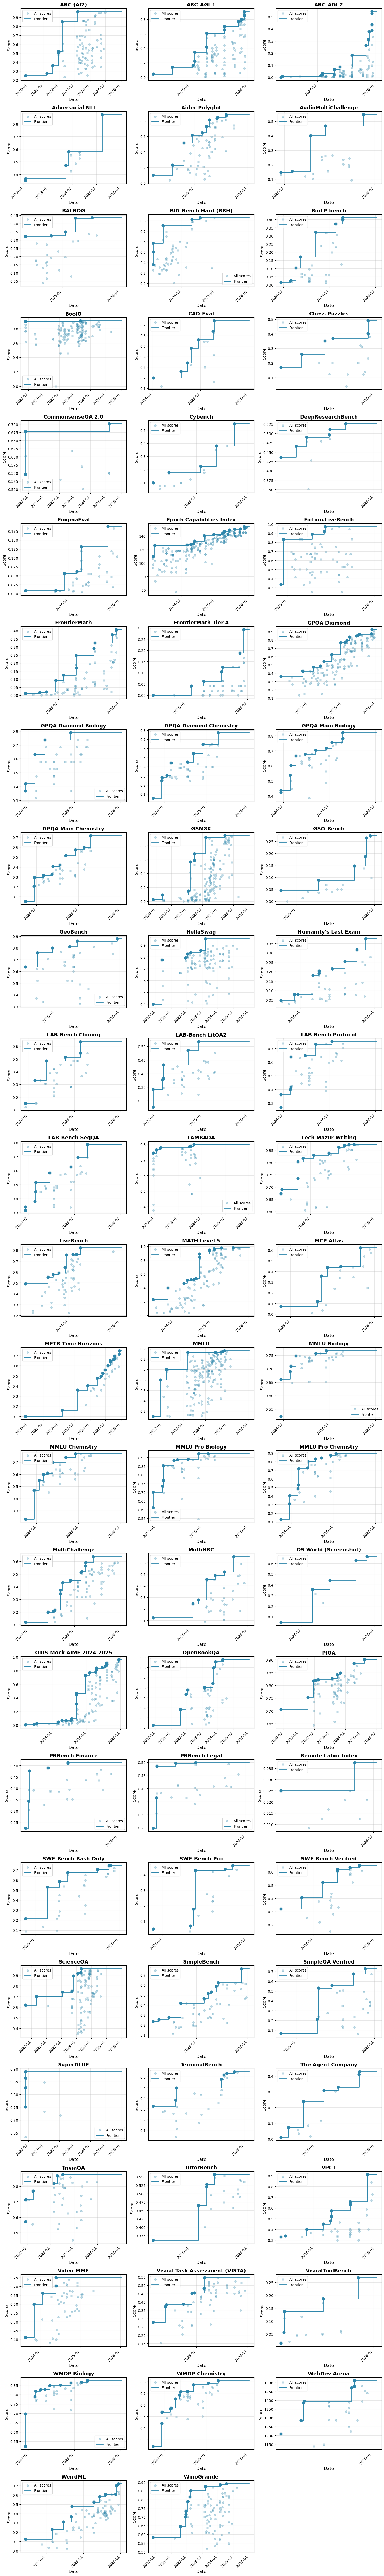

In [156]:
# ============================================================================
# VISUALIZE ALL BENCHMARKS FROM CSV
# ============================================================================

# Extract benchmark matrices from loaded data
all_benchmark_matrices_csv = extract_benchmark_matrices(df_all_benchmarks)

# Print summary
print_benchmark_summary(all_benchmark_matrices_csv)

# Plot all benchmarks in a grid
print("\n" + "="*80)
print("PLOTTING ALL BENCHMARKS")
print("="*80)

plot_all_benchmarks_grid(df_all_benchmarks, cols=3, figsize=(5, 4))

In [164]:
all_benchmark_matrices_csv["Remote Labor Index"]

{'df_long':          date                           model_id  avg_score  stderr  \
 0  2025-03-06                          Manus 1.0     0.0250     0.0   
 1  2025-06-05       gemini-2.5-pro-preview-06-05     0.0083     0.0   
 2  2025-07-17                      ChatGPT agent     0.0125     0.0   
 3  2025-08-07                   gpt-5-2025-08-07     0.0167     0.0   
 4  2025-09-29                  claude-4-5-Sonnet     0.0208     0.0   
 5  2025-10-16                          Manus 1.5     0.0250     0.0   
 6  2025-11-01  claude-opus-4-5-20251101-thinking     0.0375     0.0   
 7  2025-11-18               gemini-3-pro-preview     0.0125     0.0   
 8  2025-12-11                 gpt-5.2-2025-12-11     0.0208     0.0   
 
   organization  
 0         None  
 1       Google  
 2       OpenAI  
 3         None  
 4    Anthropic  
 5         None  
 6    Anthropic  
 7       Google  
 8         None  ,
 'df_wide':             ChatGPT agent  Manus 1.0  Manus 1.5  claude-4-5-Sonnet  \
 202

## Export processed benchmarks

In [158]:
# ============================================================================
# EXPORT BENCHMARK DATA
# ============================================================================

# Create output directory
output_dir = "benchmark_data_processed"
os.makedirs(output_dir, exist_ok=True)

# Export the processed EpochAI benchmark DataFrame
output_path = os.path.join(output_dir, "epochai_benchmarks.csv")
df_epochai.to_csv(output_path, index=False)
print(f"✓ Exported df_epochai to {output_path}")

✓ Exported df_epochai to benchmark_data_processed/epochai_benchmarks.csv


In [159]:
output_path = Path("benchmark_data_processed/scale_benchmarks.csv")
df_scale.to_csv(output_path, index=False)
print(f"\n✓ Saved formatted Scale data to {output_path}")


✓ Saved formatted Scale data to benchmark_data_processed/scale_benchmarks.csv


In [160]:
# ============================================================================
# EXPORT ALL BENCHMARKS
# ============================================================================

# Save merged data
output_path = Path("benchmark_data_processed/all_benchmarks.csv")
df_all_benchmarks.to_csv(output_path, index=False)

print(f"\n✓ Saved to {output_path}")

# Show summary by source
print("\nRecords by source:")
print(df_all_benchmarks['source'].value_counts())

print("\nBenchmarks by source:")
print(df_all_benchmarks.groupby('source')['benchmark'].nunique())


✓ Saved to benchmark_data_processed/all_benchmarks.csv

Records by source:
source
EpochAI    2626
RAND        525
Scale       392
ARC-AGI     208
Name: count, dtype: int64

Benchmarks by source:
source
ARC-AGI     2
EpochAI    44
RAND       15
Scale      13
Name: benchmark, dtype: int64


In [161]:
# ============================================================================
# SAVE VERSION WITHOUT UNNORMALIZED BENCHMARKS
# ============================================================================

# Filter out unnormalized benchmarks
df_all_normalized = df_all_benchmarks[
    ~df_all_benchmarks['benchmark'].apply(is_unnormalized_benchmark)
].copy()

# Save normalized-only version
output_path_normalized = Path("benchmark_data_processed/all_normalized_benchmarks.csv")
df_all_normalized.to_csv(output_path_normalized, index=False)

In [167]:
# ============================================================================
# SAVE VERSION WITH ONLY RECENTLY UPDATED BENCHMARKS (top-3 frontier after 2025)
# ============================================================================

cutoff_date = date(2025, 1, 1)
saturation_threshold = 0.95

# For each benchmark, compute the top-3 frontier and check for recent datapoints
# (informational only - not used for filtering)
benchmarks_with_recent_frontier = []
benchmarks_without_recent_frontier = []

for benchmark in df_all_normalized['benchmark'].unique():
    frontier = extract_frontier(df_all_normalized, benchmark, top_n=3)
    if frontier.empty:
        benchmarks_without_recent_frontier.append((benchmark, "No frontier data"))
        continue
    
    # Check if any top-3 frontier point is after cutoff OR max score > saturation threshold
    recent_frontier = frontier[frontier['date'] >= cutoff_date]
    max_score = frontier['score'].max()
    
    if len(recent_frontier) > 0 or max_score > saturation_threshold:
        benchmarks_with_recent_frontier.append(benchmark)
    else:
        latest = frontier['date'].max()
        reason = f"latest frontier: {latest}, max score: {max_score:.2f}"
        benchmarks_without_recent_frontier.append((benchmark, reason))

print(f"{'='*70}")
print(f"BENCHMARK FRONTIER ANALYSIS (informational)")
print(f"{'='*70}")
print(f"\nTotal benchmarks: {df_all_normalized['benchmark'].nunique()}")
print(f"Benchmarks with recent frontier (after {cutoff_date}) or saturated (>{saturation_threshold}): {len(benchmarks_with_recent_frontier)}")
print(f"Benchmarks without recent frontier: {len(benchmarks_without_recent_frontier)}")

if benchmarks_without_recent_frontier:
    print(f"\n📊 Benchmarks without recent frontier data:")
    for item in sorted(benchmarks_without_recent_frontier, key=lambda x: x[0]):
        print(f"    - {item[0]} ({item[1]})")

# ============================================================================
# MANUAL EXCLUSION: Benchmarks not updated with latest frontier models
# ============================================================================

# These benchmarks are not being actively updated with scores from the latest 
# frontier models (e.g., GPT-5, Claude 4, Gemini 2.5, o3, etc.)
MANUALLY_EXCLUDED_BENCHMARKS = [
    "BIG-Bench Hard (BBH)",
    "BoolQ", 
    "LAMBADA",
    "MMLU",
    "MMLU Biology",
    "MMLU Chemistry",
    "SuperGLUE",
    "TriviaQA",
    "Video-MME",
    "CommonsenseQA 2.0",
    "GPQA Main Biology",
    "GPQA Main Chemistry",
]

print(f"\n{'='*70}")
print("MANUAL EXCLUSION: Benchmarks not updated with latest frontier models")
print(f"{'='*70}")
print(f"\nThe following benchmarks are excluded because they lack scores from")
print(f"recent frontier models (GPT-5, Claude 4, Gemini 2.5, o3, etc.):")
for bench in MANUALLY_EXCLUDED_BENCHMARKS:
    print(f"    - {bench}")

# Get all benchmarks and apply only manual exclusion
all_benchmarks = df_all_normalized['benchmark'].unique().tolist()
benchmarks_final = [
    b for b in all_benchmarks 
    if b not in MANUALLY_EXCLUDED_BENCHMARKS
]

print(f"\nTotal benchmarks: {len(all_benchmarks)}")
print(f"Manually excluded: {len(MANUALLY_EXCLUDED_BENCHMARKS)}")
print(f"Benchmarks after manual exclusion: {len(benchmarks_final)}")

# Filter to only include final benchmarks
df_all_normalized_updated = df_all_normalized[
    df_all_normalized['benchmark'].isin(benchmarks_final)
].copy()

# Save updated version
output_path_updated = Path("benchmark_data_processed/all_normalized_updated_benchmarks.csv")
df_all_normalized_updated.to_csv(output_path_updated, index=False)

print(f"\n✓ Saved updated benchmarks to {output_path_updated}")
print(f"  Records: {len(df_all_normalized_updated)}")
print(f"  Benchmarks: {df_all_normalized_updated['benchmark'].nunique()}")

BENCHMARK FRONTIER ANALYSIS (informational)

Total benchmarks: 72
Benchmarks with recent frontier (after 2025-01-01) or saturated (>0.95): 62
Benchmarks without recent frontier: 10

📊 Benchmarks without recent frontier data:
    - BIG-Bench Hard (BBH) (latest frontier: 2024-12-26, max score: 0.83)
    - BoolQ (latest frontier: 2023-06-22, max score: 0.91)
    - GSM8K (latest frontier: 2024-11-21, max score: 0.94)
    - LAMBADA (latest frontier: 2023-09-06, max score: 0.80)
    - MMLU (latest frontier: 2024-12-26, max score: 0.88)
    - OpenBookQA (latest frontier: 2024-04-23, max score: 0.88)
    - SuperGLUE (latest frontier: 2021-01-11, max score: 0.89)
    - TriviaQA (latest frontier: 2023-07-11, max score: 0.88)
    - Video-MME (latest frontier: 2024-12-06, max score: 0.75)
    - WinoGrande (latest frontier: 2024-07-23, max score: 0.89)

MANUAL EXCLUSION: Benchmarks not updated with latest frontier models

The following benchmarks are excluded because they lack scores from
recent fr

Not updated with the latest frontier models: BBH, BoolQ, LAMBADA, MMLU, SuperGLUE, TriviaQA, Video-MME